 <span style="color:#42a5f5; font-size:2em; font-weight:bold;">Modélisation des séries temporelles sur les données d'incidents</span>

Prévision des Incidents des Pompiers de Londres 

L'objectif étant de prédire les interventions futurs des pompiers dans les années à venir afin de mieux organiser leur equipes, leurs materiel, et leur temps d'interventions ...

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques necessaires</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<span style="color:#e91e63; font-size:1em; font-weight:bold;">2-Chargement des données et vérifications </span>

In [2]:
# Chargement
processed_file_path = r"..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez vérifier le chemin.")

print(f"Chargement du fichier : {processed_file_path}")

# Colonnes utiles pour la time series
cols_to_keep = [
    "IncidentNumber", "DateOfCall", "TimeOfCall", "HourOfCall", "IncidentGroup", "IncGeo_BoroughName",
    "NumCalls", "NotionalCost", "PumpCount",
    "NumPumpsAttending", "NumStationsWithPumpsAttending"
]

# Typage strict uniquement sur les colonnes conservées
dtype_map = {
    "IncidentNumber": "string",
    "TimeOfCall": "string",
    "HourOfCall": "Int64",
    "IncidentGroup": "string",
    "IncGeo_BoroughName": "string",
    "NumCalls": "Int64",
    "NotionalCost": "Int64",
    "PumpCount": "Int64",
    "NumPumpsAttending": "Int64",
    "NumStationsWithPumpsAttending": "Int64",
}

Chargement du fichier : ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3-Analyse et vérification des colonnes à mettre en Index date temps </span>

In [3]:
print(" ~~ Début de la Modélisation des Séries Temporelles ~~ ")

#Vérification des datas chargées et leur formatpour la suite:
# Chargement avec conversion explicite
df = pd.read_csv(processed_file_path, usecols=cols_to_keep, dtype=dtype_map, parse_dates=['DateOfCall'], dayfirst=True)
# Vérification du chargement
print(f"- Chargement du fichier {processed_file_path} réussi.")
# Vérification des types de données
print("- Types de données dans le DataFrame :")
print(df.dtypes)
#vérification des valeurs manquantes
print("- Valeurs manquantes par colonne :")
print(df.isnull().sum())
# Vérification des bornes
print(f"Période : de {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")
# Vérifie les types uniques dans ta colonne DateOfCall
print(df['DateOfCall'].apply(type).value_counts())

'''~~~~~~~~~~~~~~~~~~~~'''

# convertir en datetime pour l'indexation: 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])
#vérification des datas apres convertion de DateOfCall en datetime pour l'indexation: 
print("-Type de la colonne DateOfCall :", df['DateOfCall'].dtype)
print("-Aperçu des valeurs de DateOfCall :")
display(df[['DateOfCall']].drop_duplicates().head(5))

print("\n-Aperçu des 5 premières lignes du DataFrame :")
display(df.head(5))
print("types de données dans le DataFrame :")
print(df.dtypes)

# Vérification des valeurs manquantes
print("-Valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\n-Statistiques descriptives :")
display(df.describe(include='all'))

print("-Période de la série temporelle :")   
print(f"De: {df['DateOfCall'].min()} au: {df['DateOfCall'].max()}")

 ~~ Début de la Modélisation des Séries Temporelles ~~ 
- Chargement du fichier ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv réussi.
- Types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                               object
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
- Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
N

,DateOfCall
0,2009-01-01
405,2009-01-02
709,2009-01-03
1093,2009-01-04
1524,2009-01-05



-Aperçu des 5 premières lignes du DataFrame :


,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,IncidentGroup,IncGeo_BoroughName,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
0,235138081,2009-01-01,00:00:37,0,Special Service,WANDSWORTH,2,2,2,255,1
1,1091,2009-01-01,00:00:46,0,Special Service,LAMBETH,<NA>,<NA>,1,255,1
2,2091,2009-01-01,00:03:00,0,Fire,ENFIELD,1,1,1,255,2
3,3091,2009-01-01,00:04:27,0,Fire,HILLINGDON,1,1,1,255,2
4,5091,2009-01-01,00:05:39,0,Fire,ISLINGTON,1,2,2,255,1


types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                       datetime64[ns]
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
-Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                        

,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,IncidentGroup,IncGeo_BoroughName,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls
count,1824973,1824973,1824973,1824973.0,1824967,1824973,1810351.0,1810351.0,1824973.0,1824973.0,1823124.0
unique,1824973,NaN,86394,<NA>,3,33,<NA>,<NA>,<NA>,<NA>,<NA>
top,21091,NaN,18:02:06,<NA>,False Alarm,WESTMINSTER,<NA>,<NA>,<NA>,<NA>,<NA>
freq,1,NaN,56,<NA>,894018,133650,<NA>,<NA>,<NA>,<NA>,<NA>
mean,NaN,2017-03-12 20:50:59.275944960,NaN,13.462605,NaN,NaN,1.370929,1.555361,1.592914,407.816033,1.327807
min,NaN,2009-01-01 00:00:00,NaN,0.0,NaN,NaN,1.0,1.0,1.0,255.0,1.0
25%,NaN,2012-09-29 00:00:00,NaN,9.0,NaN,NaN,1.0,1.0,1.0,290.0,1.0
50%,NaN,2017-04-15 00:00:00,NaN,14.0,NaN,NaN,1.0,1.0,1.0,328.0,1.0
75%,NaN,2021-09-02 00:00:00,NaN,19.0,NaN,NaN,2.0,2.0,2.0,364.0,1.0
max,NaN,2025-03-31 00:00:00,NaN,23.0,NaN,NaN,46.0,106.0,951.0,2277726.0,369.0


-Période de la série temporelle :
De: 2009-01-01 00:00:00 au: 2025-03-31 00:00:00


In [4]:
#vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

# Préprocessing et traitement des valeurs manquantes de la colonne IncidentGroup qui contient 6 valeurs manquantes
# Remplacement des valeurs manquantes dans 'IncidentGroup' par 'False Alarm'
df['IncidentGroup'].fillna('False Alarm', inplace=True)

# Vérification que l'imputation a fonctionné
missing_after = df['IncidentGroup'].isnull().sum()
print(f"Valeurs manquantes restantes dans IncidentGroup : {missing_after}")

# Contrôle de la répartition finale
print("\nRépartition des valeurs dans IncidentGroup après imputation :")
print(df['IncidentGroup'].value_counts())

Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64
Valeurs manquantes restantes dans IncidentGroup : 0

Répartition des valeurs dans IncidentGroup après imputation :
IncidentGroup
False Alarm        894024
Special Service    598275
Fire               332674
Name: count, dtype: Int64


In [ ]:
'''#Vérification des données entre le 3 et 31 mars 2025
print("\n- Vérification des données entre le 3 et 31 mars 2025 :")
# Conversion 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], dayfirst=True, errors='coerce')

# Sélection des lignes entre 3 mars et 31 mars 2025
mask_march25 = (df['DateOfCall'] >= '2025-03-03') & (df['DateOfCall'] <= '2025-03-31')
df_march25 = df.loc[mask_march25, ['DateOfCall', 'TimeOfCall']]

# VérifiCATION s'il y a des valeurs manquantes dans TimeOfCall
missing_time = df_march25['TimeOfCall'].isna().sum()
total_rows = df_march25.shape[0]

print(f"\nSur {total_rows} lignes entre le 3 et le 31 mars 2025 :")
print(f"- {missing_time} lignes ont TimeOfCall manquant")
print(f"- {total_rows - missing_time} lignes ont un TimeOfCall valide")

# V2RIFIE SIR IL Y A Des lignes manquantes
if missing_time > 0:
    print("\nVoici un aperçu des lignes concernées (DateOfCall sans TimeOfCall) :")
    display(df_march25[df_march25['TimeOfCall'].isna()])'''


- Vérification des données entre le 3 et 31 mars 2025 :

Sur 340 lignes entre le 3 et le 31 mars 2025 :
- 0 lignes ont TimeOfCall manquant
- 340 lignes ont un TimeOfCall valide



<span style="color:#e91e63; font-size:1em; font-weight:bold;">4-Construction de l'Indexation</span>

In [5]:
# Si nécessaire, on trie d'abord les dates
df = df.sort_values('DateOfCall')
#cree la colonne datetemi me à partir de DateOfCall et TimeOfCall
# On crée une colonne DateTime à partir de DateOfCall et TimeOfCall
df['DateTime'] = pd.to_datetime(df['DateOfCall'].astype(str) + ' ' + df['TimeOfCall'], errors='coerce')
# Vérification de la conversion
print("\n- Type de la colonne DateTime :", df['DateTime'].dtype)    


# On crée une colonne dédiée
df['DateOfCall_str'] = df['DateOfCall'].dt.strftime('%Y-%m-%d')

# On fait une copie de la colonne pour l'index (index datetime)
df = df.set_index('DateTime').sort_index()

# Vérification visuelle
print("\nIndexation OK")
print(f"Index DateOfCall : de {df.index.min().date()} à {df.index.max().date()}")
print(f"Nombre de lignes indexées : {df.shape[0]}")

# DateOfCall_str si besoin d'une version lisible
display(df.head())


- Type de la colonne DateTime : datetime64[ns]

Indexation OK
Index DateOfCall : de 2009-01-01 à 2025-03-31
Nombre de lignes indexées : 1824973


,IncidentNumber,DateOfCall,TimeOfCall,HourOfCall,IncidentGroup,IncGeo_BoroughName,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,NotionalCost,NumCalls,DateOfCall_str
DateTime,,,,,,,,,,,,
2009-01-01 00:00:37,235138081,2009-01-01,00:00:37,0,Special Service,WANDSWORTH,2,2,2,255,1,2009-01-01
2009-01-01 00:00:46,1091,2009-01-01,00:00:46,0,Special Service,LAMBETH,<NA>,<NA>,1,255,1,2009-01-01
2009-01-01 00:03:00,2091,2009-01-01,00:03:00,0,Fire,ENFIELD,1,1,1,255,2,2009-01-01
2009-01-01 00:04:27,3091,2009-01-01,00:04:27,0,Fire,HILLINGDON,1,1,1,255,2,2009-01-01
2009-01-01 00:05:39,5091,2009-01-01,00:05:39,0,Fire,ISLINGTON,1,2,2,255,1,2009-01-01


In [ ]:
'''# Vérifie que TimeOfCall est bien une chaîne au format hh:mm:ss
# Si jamais TimeOfCall n'a pas les secondes, on les ajoute artificiellement
df['TimeOfCall'] = df['TimeOfCall'].apply(lambda x: x if len(x.split(':')) == 3 else x + ':00')

# Maintenant, tu peux forcer DateTime proprement
df['DateTime'] = pd.to_datetime(df['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df['TimeOfCall'],errors='coerce')

# Correction claire

# Mets DateTime en index
df.set_index('DateTime', inplace=True)

# Vérification
print("\nIndexation DateTime OK")
print(f"Index DateTime : de {df.index.min()} à {df.index.max()}")
print(f"DateOfCall : de {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")
display(df.describe(include='all'))'''


In [ ]:
'''# vérification : si dans la période du 1er au 31 mars 2025, il reste des valeurs problématiques entre DateOfCall et TimeOfCall qui empêcheraient la création d'une colonne DateTime correcte.
# Vérifie si des lignes sont invalides entre le 3 et 31 mars
df_check = df[(df['DateOfCall'] >= '2025-03-01') & (df['DateOfCall'] <= '2025-03-31')].copy()

# Création  d'une colonne DateTime provisoire
df_check['DateTime_temp'] = pd.to_datetime(
    df_check['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df_check['TimeOfCall'].astype(str),
    errors='coerce'
)

# Montre les lignes posant problème
invalid = df_check[df_check['DateTime_temp'].isna()]
print(f"\nNombre de lignes mal converties entre le 3 et 31 mars : {len(invalid)}")

if not invalid.empty:
    display(invalid[['DateOfCall', 'TimeOfCall']].head(20))'''


<span style="color:#e91e63; font-size:1em; font-weight:bold;">5-Vérifications des appels reçus qui déclenchent les interventions  </span>

Valeurs uniques dans NumCalls :
<IntegerArray>
[  1,   2,   7,   3,  16,   6,   4,   5,  12,  17,
 ...
 103,  60,  58, 124,  80,  82,  71,  99, 127, 210]
Length: 102, dtype: Int64


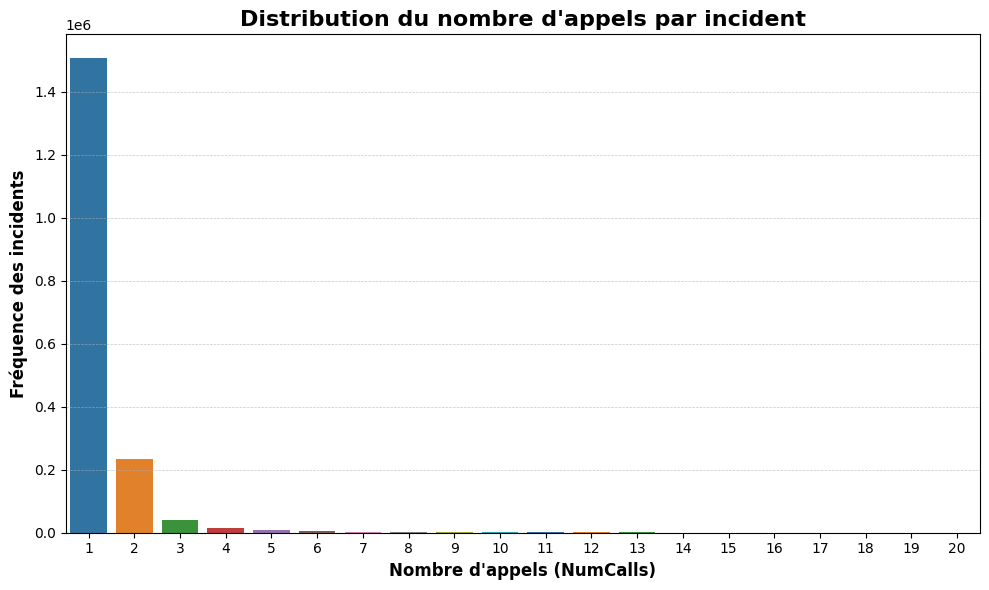

In [6]:
# Analyse de la colonne NumCalls pour determiner les appels pour chaque incident:
# Analyse des valeurs uniques de NumCalls
print("Valeurs uniques dans NumCalls :")
print(df["NumCalls"].unique())

# on réinitialise l’index SANS toucher au df original
num_df = df[df['NumCalls'] <= 20].reset_index(drop=True)

# ordre des barres : du plus fréquent au moins fréquent
order = num_df['NumCalls'].value_counts().index 

# Distribution de NumCalls
plt.figure(figsize=(10, 6))
sns.countplot(data=num_df, x='NumCalls', order=order, palette='tab10')
plt.title("Distribution du nombre d'appels par incident", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels (NumCalls)", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence des incidents", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Environ 90–95 % (visuellement estimé) des incidents ne sont associés qu’à un seul appel !
Cela suggère que pour la plupart des situations, un seul appel suffit à déclencher l’intervention ou à gérer l’incident.

In [7]:
# 1) Lignes où NumCalls est manquant
na_calls = df[df["NumCalls"].isna()]
print(f"Nombre de lignes avec NumCalls manquant : {na_calls.shape[0]}")

# 1-a) Y a-t-il plusieurs enregistrements pour le même IncidentNumber ?
dup_incidents = na_calls.duplicated(subset="IncidentNumber").sum()
print(f"Duplications sur IncidentNumber parmi les NA : {dup_incidents}")

# 1-b) Distribution (rapide) d’autres indicateurs pour comparer aux incidents « normaux »
cols_check = ["NotionalCost", "PumpCount", "NumPumpsAttending", "IncidentGroup", "IncidentNumber", "DateOfCall_str", "IncGeo_BoroughName"]
print("\nRésumé stats des colonnes comparatives :")
display(na_calls[cols_check].describe())

# 1-c) Profil des groupes d’incident
print("\nTop 10 des IncidentGroup pour NA :")
print(na_calls["IncidentGroup"].value_counts().head(10))

Nombre de lignes avec NumCalls manquant : 1849
Duplications sur IncidentNumber parmi les NA : 0

Résumé stats des colonnes comparatives :


,NotionalCost,PumpCount,NumPumpsAttending
count,1849.0,1849.0,1793.0
mean,318.4543,1.611141,1.597881
std,530.075481,0.962897,0.778145
min,255.0,1.0,1.0
25%,260.0,1.0,1.0
50%,260.0,1.0,1.0
75%,290.0,2.0,2.0
max,14234.0,16.0,6.0



Top 10 des IncidentGroup pour NA :
IncidentGroup
False Alarm        1319
Fire                327
Special Service     203
Name: count, dtype: Int64


Pas de doublons sur IncidentNumber, Chaque ligne est un incident unique car pas de doublons	
PumpCount ≥ 1 (min = 1, mean ≈ 1,6)	Au moins un engin s’est déplacé → il y a eu  donc un vrai appel !	
NotionalCost ≥ 255 £ (coût > 0 pour toutes)	Un coût est logiquement généré seulement si l’appel est valide !
IncidentGroup majoritairement “False Alarm” (71 %)	Même pour une fausse alerte, il faut au moins un appel pour déclencher l’intervention

Décision: ==>Imputation des NA en 1 

In [8]:
# Traitement des valeurs manquantes dans NumCalls
# 1. Identifier les lignes avec NumCalls manquant:
numcalls_na = df["NumCalls"].isna()

# 2. Déterminer si l'incident montre une vraie intervention (coût ou engin mobilisé):
intervention_probable = (
    (df["PumpCount"] > 0) |
    (df["NumPumpsAttending"] > 0) |
    (df["NotionalCost"] > 0)
)

# 3. Imputer 1 appel si une intervention est probable:
df.loc[numcalls_na & intervention_probable, "NumCalls"] = 1

# 4. Pour les rares cas restants, imputer 0:
df["NumCalls"].fillna(0, inplace=True)

# 5. Vérification:

print("\nDistribution finale des valeurs de NumCalls :")
print(df["NumCalls"].value_counts(dropna=False).sort_index())
# Nombre total de lignes dans NumCalls
nb_lignes_numcalls = df["NumCalls"].shape[0]
print(f"Nombre total de lignes dans NumCalls : {nb_lignes_numcalls}")

# Vérifie qu'il n'y a plus de NA
print("\nValeurs manquantes dans apres imputation NumCalls :")
print(df["NumCalls"].isna().sum())

# Résumé statistique
print("\nStatistiques descriptives de NumCalls :")
print(df["NumCalls"].describe())


Distribution finale des valeurs de NumCalls :
NumCalls
1      1509185
2       233663
3        39154
4        13688
5         7635
        ...   
144          1
161          1
175          1
210          1
369          1
Name: count, Length: 101, dtype: Int64
Nombre total de lignes dans NumCalls : 1824973

Valeurs manquantes dans apres imputation NumCalls :
0

Statistiques descriptives de NumCalls :
count    1824973.0
mean      1.327474
std       1.486381
min            1.0
25%            1.0
50%            1.0
75%            1.0
max          369.0
Name: NumCalls, dtype: Float64


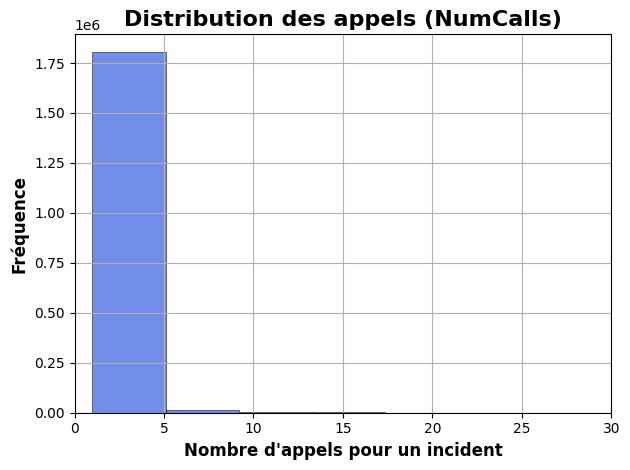

In [9]:
# Histogramme centré sur les valeurs les plus courantes des appels
sns.histplot(df["NumCalls"], bins=90, color="royalblue")
plt.xlim(0, 30)  
plt.title("Distribution des appels (NumCalls)", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels pour un incident", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence", fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution très déséquilibrée:
La quasi-totalité des incidents sont associés à très peu d'appels (typiquement entre 1 et 5)


- Etude de appels par différentes dimensions
 taille: Hourly : (142416, 15) | Daily : (5934, 15) | Weekly : (849, 15) | Monthly : (195, 15) | Yearly : (17, 15)


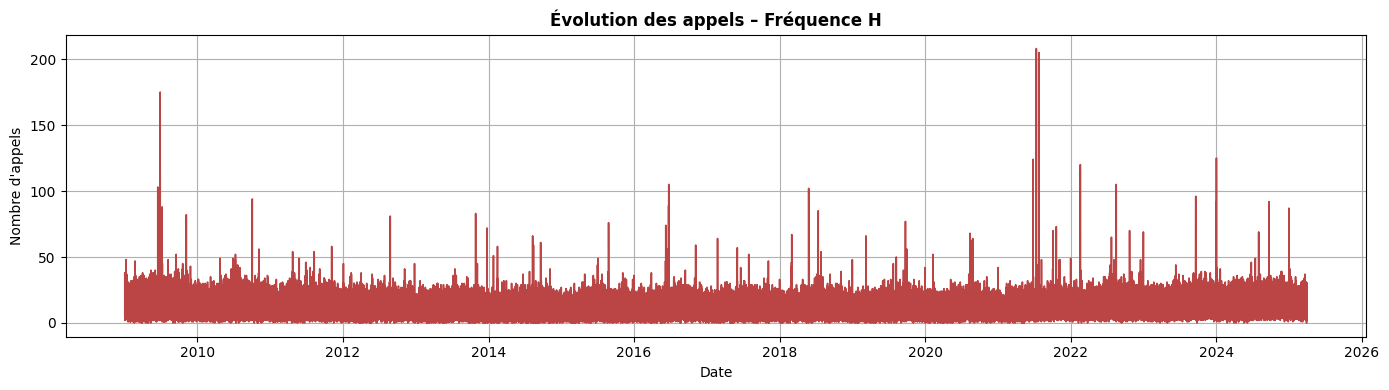

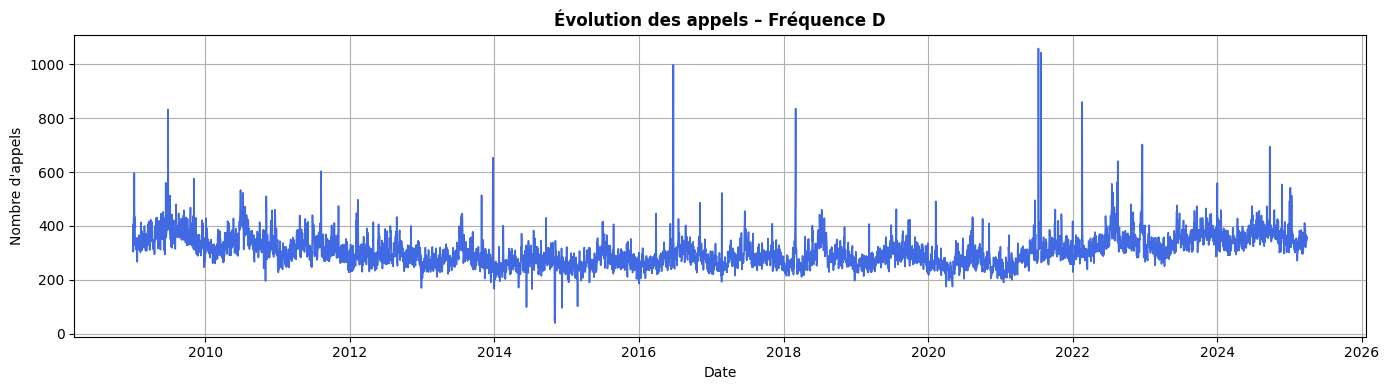

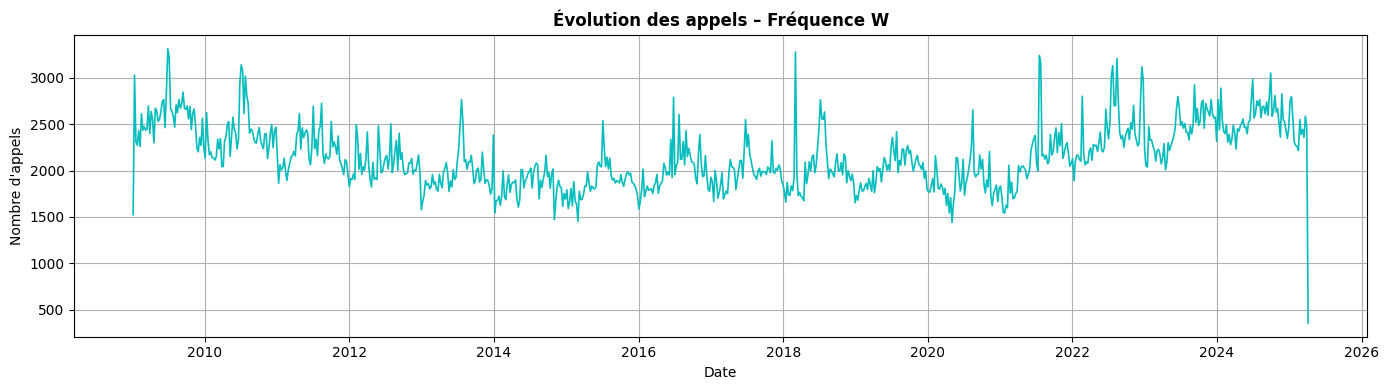

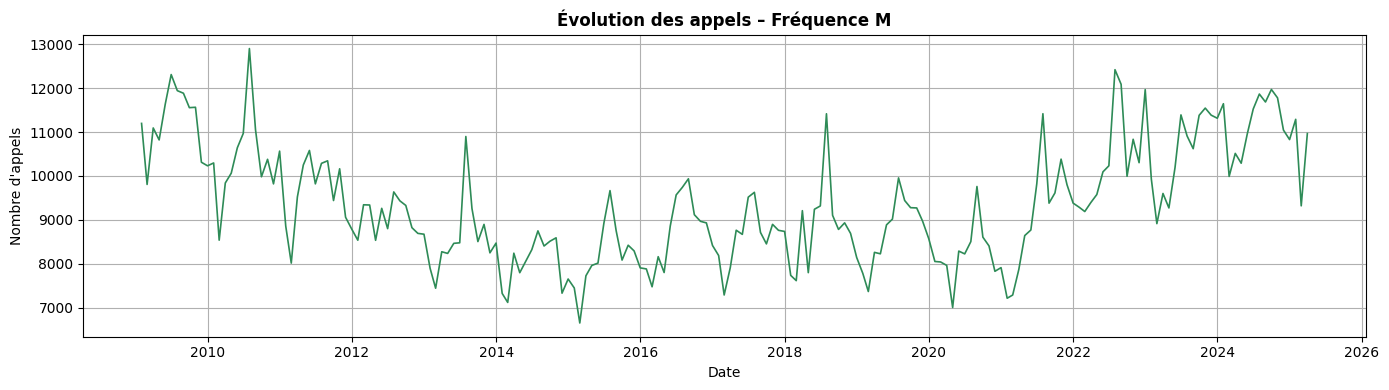

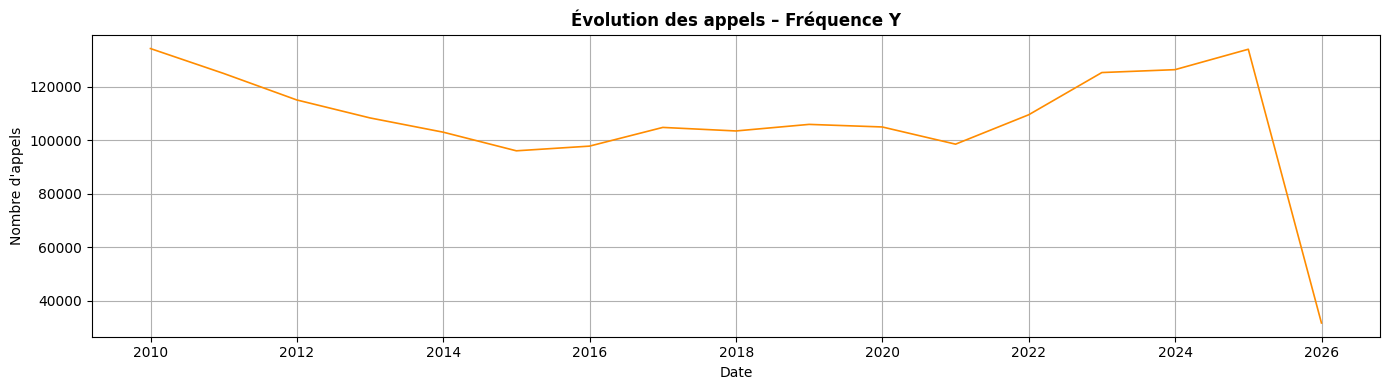

,weekday,hour,NumCalls_count,NumCalls_sum,NumCalls_mean,NotionalCost_count,NotionalCost_sum,NotionalCost_mean,PumpCount_count,PumpCount_sum,PumpCount_mean,NumPumpsAttending_count,NumPumpsAttending_sum,NumPumpsAttending_mean,NumStationsWithPumpsAttending_count,NumStationsWithPumpsAttending_sum,NumStationsWithPumpsAttending_mean
0,0,0,7719,11166,1.44656,7719,3155218,408.759943,7719,12483,1.617178,7665,12072,1.574951,7665,10425,1.360078
1,0,1,6447,9419,1.46099,6447,2917203,452.489995,6447,10462,1.62277,6380,9985,1.565047,6380,8584,1.345455
2,0,2,5238,7772,1.483772,5238,2791527,532.937572,5238,8805,1.680985,5152,8225,1.596467,5152,7045,1.36743
3,0,3,4474,6533,1.460215,4474,1976614,441.800179,4474,7305,1.632767,4374,6970,1.593507,4374,6003,1.372428
4,0,4,4063,5463,1.344573,4063,1820540,448.077775,4063,6713,1.652227,3998,6375,1.594547,3998,5496,1.374687


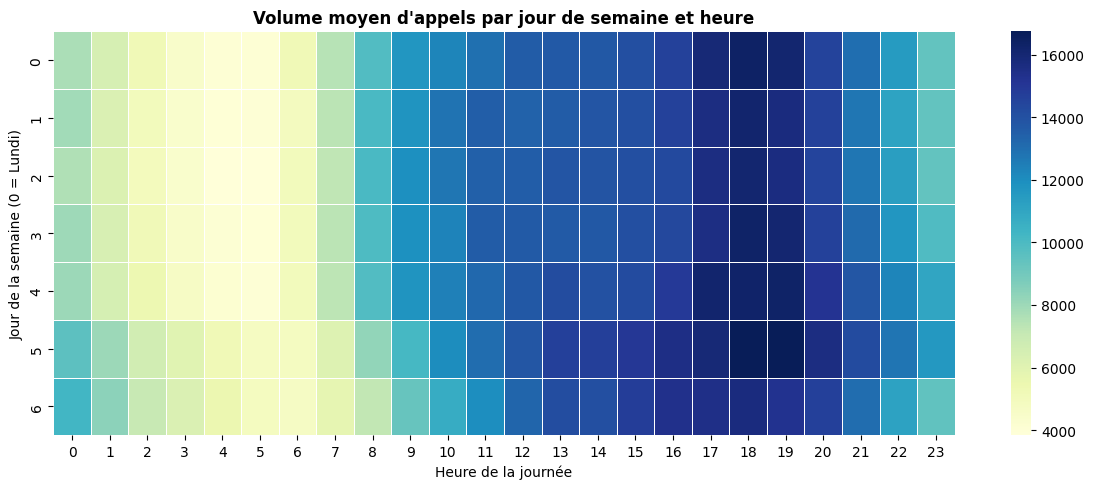

In [10]:
# Etude de appels par differentes dimensions
print("\n- Etude de appels par différentes dimensions")
# Enrichissement calendaire
df = df.assign(
    year=df.index.year,
    quarter=df.index.quarter,
    month=df.index.month,
    week=df.index.isocalendar().week,
    weekday=df.index.dayofweek,  # 0 = lundi
    day=df.index.day,
    hour=df.index.hour
).astype({
    "year": "Int64", "quarter": "Int64", "month": "Int64", "week": "Int64",
    "weekday": "Int64", "day": "Int64", "hour": "Int64"
})

# Fonctions d'agrégation
NUM_COLS = ["NumCalls", "NotionalCost", "PumpCount", "NumPumpsAttending", "NumStationsWithPumpsAttending"]
DEFAULT_FUNCS = ["count", "sum", "mean"]

def aggregate_by_time(freq="D", columns=NUM_COLS, funcs=DEFAULT_FUNCS):
    """ Agrège les colonnes numériques par fréquence temporelle """
    agg_map = {col: funcs for col in columns}
    df_ts = df.resample(freq).agg(agg_map)
    df_ts.columns = [f"{col}_{func}" for col, func in df_ts.columns.to_flat_index()]
    return df_ts


def aggregate_by_dimensions(dims=("weekday", "hour"), columns=NUM_COLS, funcs=DEFAULT_FUNCS, dropna=True):
    """ Cube multi-index pour analyses croisées temporelles """
    agg_map = {col: funcs for col in columns}
    df_cube = df.groupby(list(dims)).agg(agg_map).reset_index()
    df_cube.columns = ["_".join(map(str, col)).strip("_") for col in df_cube.columns]
    return df_cube.dropna(how="all", axis=1) if dropna else df_cube

# Fonction de visualisation
def plot_timeseries(data, freq_label, color, y_col="NumCalls_count"):
    plt.figure(figsize=(14, 4))
    plt.plot(data.index, data[y_col], color=color, linewidth=1.2)
    plt.title(f"Évolution des appels – Fréquence {freq_label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'appels")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Agrégations temporelles
df_hourly  = aggregate_by_time("H")
df_daily   = aggregate_by_time("D")
df_weekly  = aggregate_by_time("W")
df_monthly = aggregate_by_time("M")
df_yearly  = aggregate_by_time("Y")

print(" taille: Hourly :", df_hourly.shape, "| Daily :", df_daily.shape, "| Weekly :", df_weekly.shape, "| Monthly :", df_monthly.shape, "| Yearly :", df_yearly.shape)

# Visualisation des séries temporelles=
COLOR_MAP = {"H": "#BB4545", "D": "royalblue", "W": "#08bdbd", "M": "seagreen", "Y": "darkorange"}

for label, data in [("H", df_hourly), ("D", df_daily), ("W", df_weekly), ("M", df_monthly), ("Y", df_yearly)]:
    plot_timeseries(data, label, COLOR_MAP[label])

# Cube Jour de Semaine x Heure
cube_weekday_hour = aggregate_by_dimensions(("weekday", "hour"))
display(cube_weekday_hour.head())

#Heatmap par heure et jour de semaine
heatmap_data = cube_weekday_hour.pivot(index="weekday", columns="hour", values="NumCalls_count").fillna(0)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data.astype(float), cmap="YlGnBu", linewidths=0.5)
plt.title("Volume moyen d'appels par jour de semaine et heure", fontweight="bold")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour de la semaine (0 = Lundi)")
plt.tight_layout()
plt.show()

Observation sur les differentes granularité d'évolution des appels:

Plus on s’éloignes dans le temps (H → D → W → M→Y), plus on gagnes en lisibilité de la tendance :   
-"Evolution des appels-Fréquence H" => À l’heure : bruit, événements extrêmes
-"Evolution des appels-Fréquence D" => Au jour : stabilisation avec pics visibles
-"Evolution des appels-Fréquence W" => À la semaine : cycles lissés
-"Evolution des appels-Fréquence M" => Au mois : tendance globale, saisonnalité très lisible
-"Évolution des appels – Fréquence Annuelle Y" => à l'année: 
2009-2015 : Déclin net du nombre d'appels, avec une perte d’environ 25% du volume initial.
2016-2020 : Phase de stabilisation entre 95k et 105k appels/an, avec de petites fluctuations sans tendance claire.
2021-2024 : Reprise forte et continue, le nombre d'appels repart à la hausse et dépasse le niveau de 2009.
2025 (partiel) : Chute brutale uniquement due au fait que les données s'arrêtent au 31 mars 2025. Cette baisse n’a rien d’opérationnel, elle est due à l’absence de données complètes.

La granularité hebdo ou mensuelle/annuelle semble la plus pertinente pour anticiper la charge.

Synthèse de la Heatmap:
Volume moyen d'appels par jour de la semaine et heure
Ce qu’on observe :
Les appels sont surtout concentrés en journée, entre 8h et 20h. C’est vraiment en fin d’après-midi, entre 16h30 et 19h, que l’on constate le plus gros pic d’activité! Mardi etant le jour avec le plus grand nombre d'appels independament de l'heure d'appel
La répartition est plutôt stable du lundi au dimanche

| Période    | Volume d’appels | Commentaire                         |
| ---------- | --------------- | ----------------------------------- |
| 2009-2014  | En baisse       | Réduction progressive d’activité    |
| 2015-2020  | Stable          | Activité consolidée                 |
| 2021-2024  | En hausse       | Reprise importante                  |
| Après 2024 | Forte chute     | 3 mois de datas 2025 insuffisant    |
|            |                 | pour observé une tendence annuelle  |

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6- Analyse de la répartition et évolution des incidents: jour, mois, heure, année   </span>

In [11]:
#vérification de l'index:
df["DateTime"] = df.index
print("Type d'index :", type(df.index))
print("Nom de l'index :", df.index.name)

Type d'index : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Nom de l'index : DateTime



Shapes des séries :
Hourly : (142416,)
Daily  : (5934,)
Weekly : (849,)
Monthly: (195,)
Yearly : (17,)


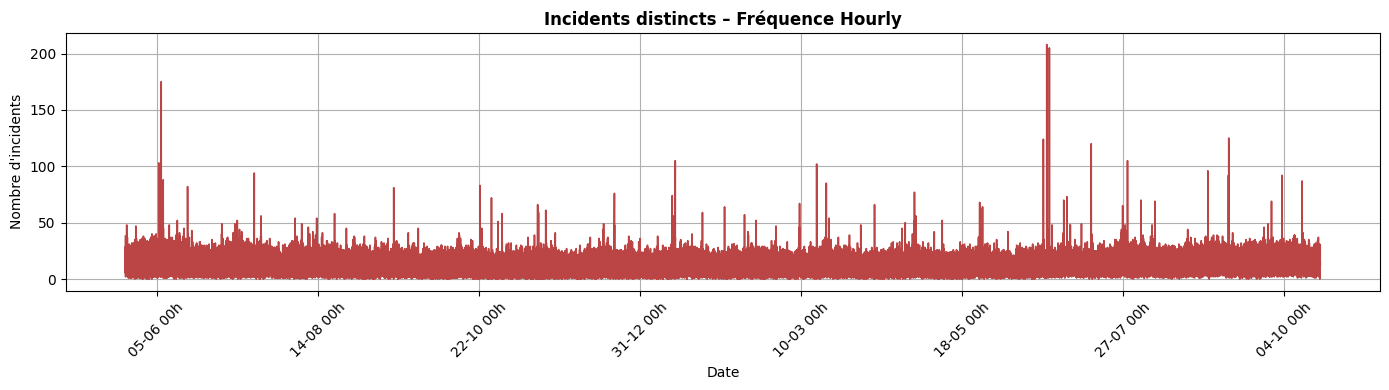

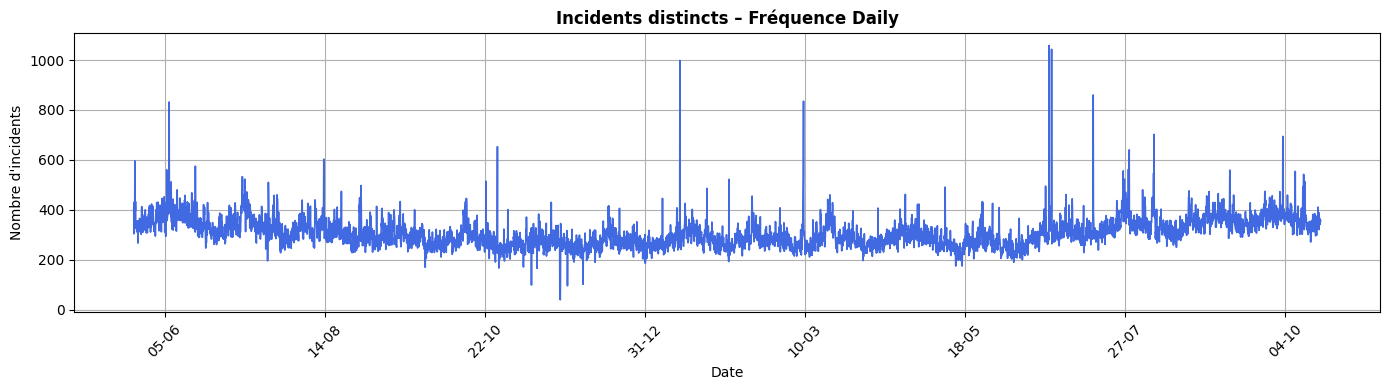

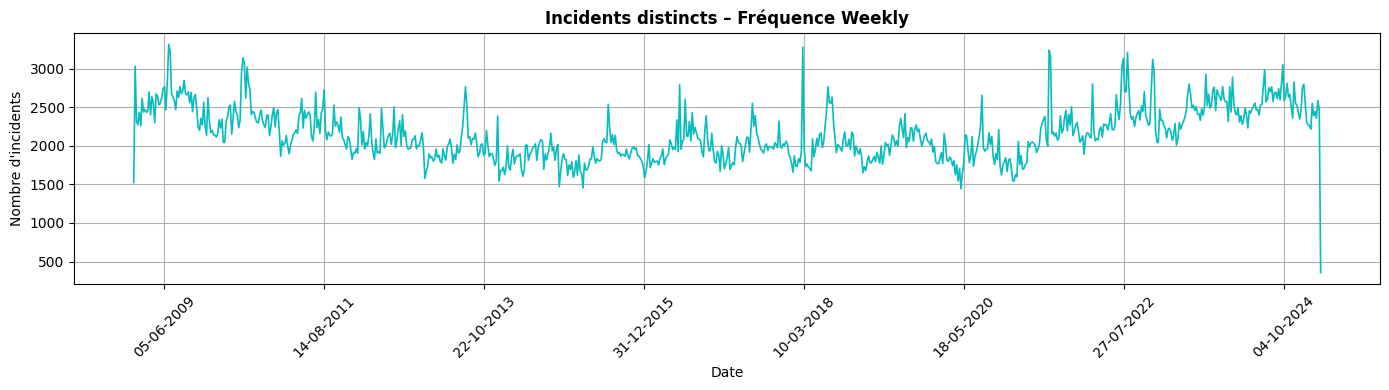

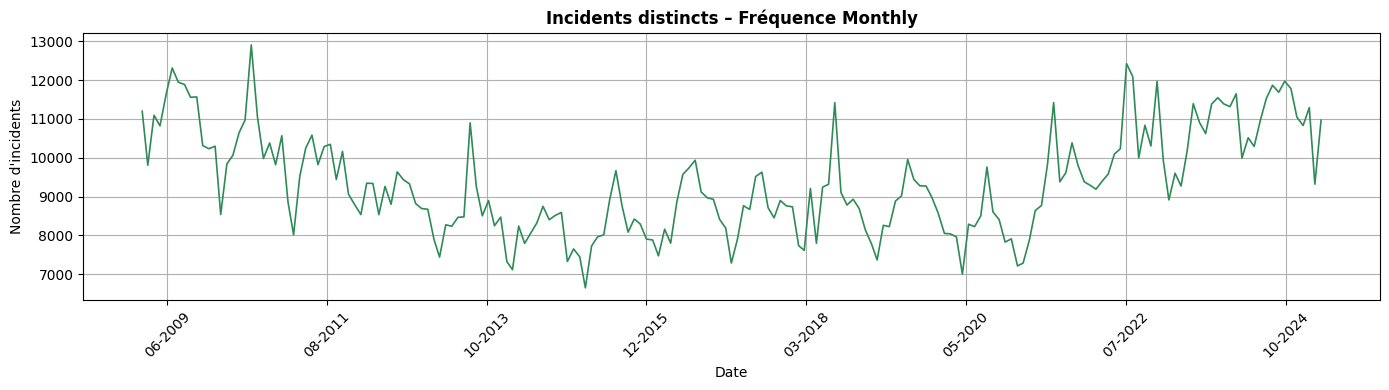

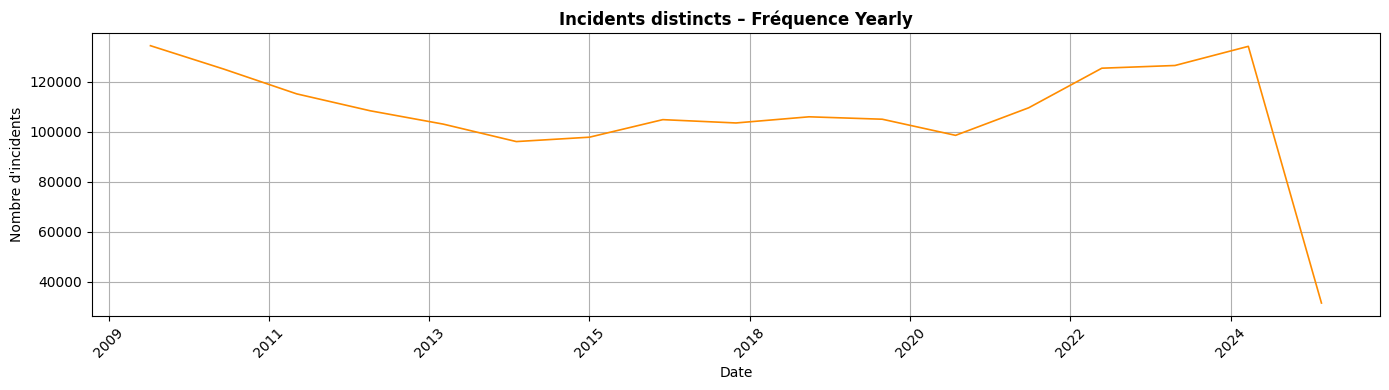

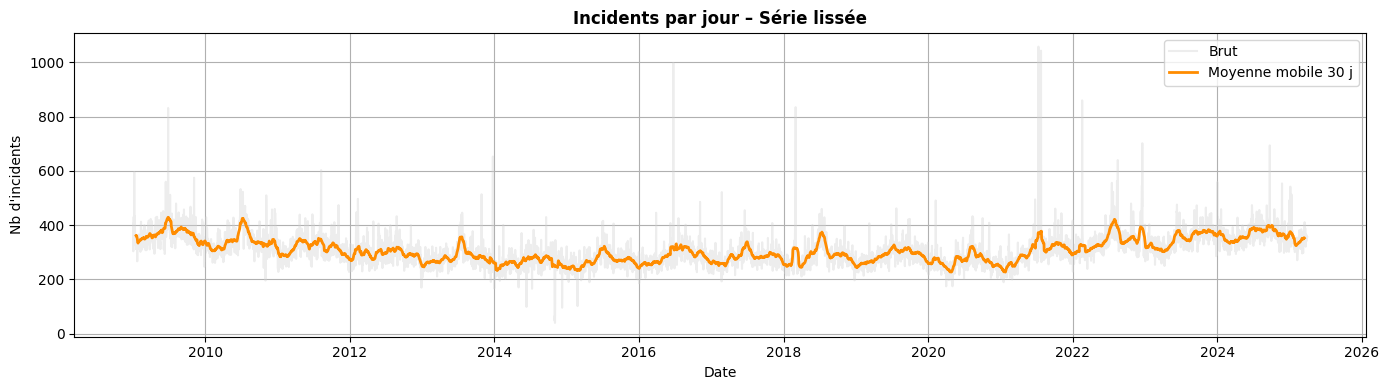

In [12]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1️⃣ Fonction d'agrégation unique
def incidents_ts(df, freq="D"):
    return df.resample(freq)["IncidentNumber"].nunique().rename("incident_count")

# 2️⃣ Séries par fréquence
frequencies = {
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}
series_dict = {label: incidents_ts(df, freq) for label, freq in frequencies.items()}

# Vérification des tailles
print("\nShapes des séries :")
for label, serie in series_dict.items():
    print(f"{label:<7}: {serie.shape}")

# 3️⃣ Visualisations homogènes
COLOR = {
    "Hourly": "#BB4545",
    "Daily": "royalblue",
    "Weekly": "#08bdbd",
    "Monthly": "seagreen",
    "Yearly": "darkorange"
}

date_format = {
    "Hourly": mdates.DateFormatter('%d-%m %Hh'),
    "Daily": mdates.DateFormatter('%d-%m'),
    "Weekly": mdates.DateFormatter('%d-%m-%Y'),
    "Monthly": mdates.DateFormatter('%m-%Y'),
    "Yearly": mdates.DateFormatter('%Y')
}

for label, serie in series_dict.items():
    plt.figure(figsize=(14, 4))
    plt.plot(serie.index, serie, color=COLOR[label], linewidth=1.2)
    plt.title(f"Incidents distincts – Fréquence {label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'incidents")
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_format[label])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4️⃣ Lissage mobile (version plus claire)
window = 30
inc_daily = series_dict["Daily"]
inc_daily_smooth = inc_daily.rolling(window=window, center=True).mean()

plt.figure(figsize=(14, 4))
plt.plot(inc_daily, color="lightgrey", alpha=0.4, label="Brut")
plt.plot(inc_daily_smooth, color="darkorange", linewidth=2, label=f"Moyenne mobile {window} j")
plt.title("Incidents par jour – Série lissée", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nb d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Observation:
Horaire (H)	Très granulaire. Des pics exceptionnels (vers 2022).
Journalier (D)	Densité très forte, très bonne base pour analyse saisonnière.
Hebdo (W)	Les cycles plus larges sont visibles ; utile pour détecter baisses structurelles.
Mensuel (M)	Super clair : on voit un effondrement des données en 2024–2025 car les données s'arrettent au 31/03/2025.


##  **Conclusion :**
* Les courbes liées a `IncidentNumber` et `NumCalls` montrent la **même dynamique à toutes les fréquences**.
* On peux **choisir l’une ou l’autre colonne pour la modélisation** selon l'objectif :

  * **NumCalls** : Volume d’appels, plus lisible métier.
  * **IncidentNumber** : Compte distinct des évènements.

**Les deux variables sont bien corrélées.**

 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 7- Décomposition saisonnières ( additive/multiplicative) </span>

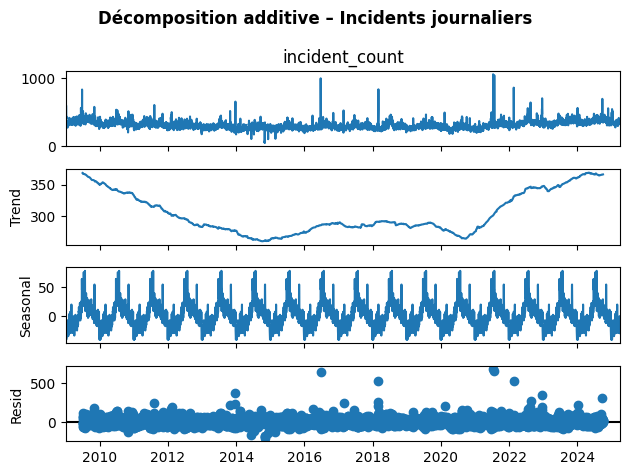

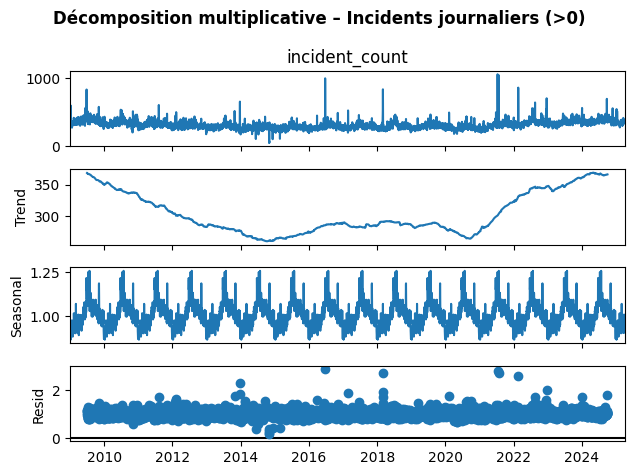

In [13]:
# 5. Décompositions saisonnières
from statsmodels.tsa.seasonal import seasonal_decompose

# a) Additive
decomp = seasonal_decompose(inc_daily, model="additive", period=365)
decomp.plot()
plt.suptitle("Décomposition additive – Incidents journaliers", fontweight="bold")
plt.tight_layout()
plt.show()

# b) Multiplicative
inc_daily_nonzero = inc_daily[inc_daily > 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)
decomp_mult.plot()
plt.suptitle("Décomposition multiplicative – Incidents journaliers (>0)", fontweight="bold")
plt.tight_layout()
plt.show()

## **Décomposition Additive : Incidents Journaliers**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle montre une baisse progressive des incidents entre 2010 et 2015, suivie d'une lente remontée jusqu'à 2024. C'est très lisible.
* **Saisonnalité (Seasonal)** : Elle est fixe dans l'additif : la même amplitude est conservée tout au long de la série. Cela signifie que le modèle suppose que les variations saisonnières (pics et creux) sont constantes dans le temps, quelles que soient les évolutions de la tendance.
* **Résidus (Resid)** : On voit des points atypiques (outliers) assez marqués, surtout vers la fin. Cela signifie que certains jours ont des valeurs très éloignées de ce qu’expliquerait la tendance et la saisonnalité seule.

### En résumé :

La décomposition **additive** est adaptée quand l'effet saisonnier est supposé constant au fil des ans. On voit des fluctuations d'ampleur similaire même quand la tendance change.


## **Décomposition Multiplicative : Incidents Journaliers (>0)**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle suit le même schéma général que l'additive, mais avec des valeurs transformées (plus proches de proportions ou rapports que de quantités brutes).
* **Saisonnalité (Seasonal)** : Ici, elle est relative : on voit qu'elle oscille autour de 1 (pas autour d'une valeur fixe) et son effet est proportionnel au niveau de la tendance. Quand la tendance est basse, l'effet saisonnier est faible, et inversement.
* **Résidus (Resid)** : Ils semblent plus homogènes, ce qui est normal car les effets disproportionnés sont "absorbés" par la multiplicativité. Mais des jours atypiques subsistent.

### En résumé :

La décomposition **multiplicative** suppose que les effets saisonniers sont proportionnels au niveau général des incidents. On voit ici que c’est plus pertinent dans les périodes où le volume change fortement : l’amplitude saisonnière est réduite quand l’activité est faible, et amplifiée quand elle est forte.



## **Comparaison générale:**

|                         | **Additive**                   | **Multiplicative**           |
| ----------------------- | ------------------------------ | ---------------------------- |
| **Saisonnalité**        | Constante                      | Proportionnelle au niveau    |
| **Lecture des résidus** | Résidus parfois très dispersés | Résidus plus homogènes       |
| **À privilégier si...** | Effets saisonniers fixes       | Effets saisonniers évolutifs |

---

## **Décision pour la suite :**

Pour **comparer des tendances de fond sur de longues périodes**, l'additif est plus facile à interpréter.
Pour **modéliser des séries où les variations saisonnières varient avec le volume**, la multiplicative est plus pertinente.

Dans ce cas, vu les fortes différences d’activité (2014, 2017, 2023...), **la multiplicative semble plus robuste** car elle s’adapte mieux aux changements de niveau d’activité.

Nous avons décidé de pousser plus loin avec une STL qui combine les avantages des deux décompostion.


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 8- Test de saisonnalité et autocorrelation  ( additive/multiplicative) </span>

In [14]:
#  6. Test de stationnarité (ADF):  
def adf_test(series):
    """ Faire le test de Dickey-Fuller augmenté (ADF) pour vérifier la stationnarité."""
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    return p_value, is_stationary
# Test sur la série journalière
p_value, is_stationary = adf_test(inc_daily)
print(f"Test ADF sur la série journalière : p-value = {p_value:.4f}, la série est-elle bien stationnaire ? {is_stationary}")


#  7. Autocorrélation et autocorrélation partielle:
def plot_acf_pacf(series, lags=50):
    """ Afficher les graphiques ACF et PACF"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series, lags=lags, ax=ax[0], title="ACF (Autocorrélation)")
    plot_pacf(series, lags=lags, ax=ax[1], title="PACF (Autocorrélation partielle)")
    plt.tight_layout()
    plt.show()

Test ADF sur la série journalière : p-value = 0.0003, la série est-elle bien stationnaire ? True


In [15]:
print("Dernière date de données :", df["DateOfCall"].max())

Dernière date de données : 2025-03-31 00:00:00


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 9-Décomposition STL</span>

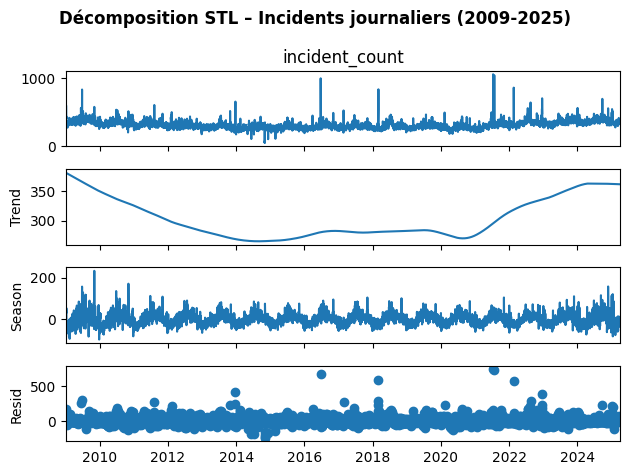

In [16]:
from statsmodels.tsa.seasonal import STL

# On recrée la série quotidienne propre à partir du DataFrame indexé
# Ici on suppose que 'IncidentNumber' est bien en index 'DateOfCall' déjà et que la colonne IncidentNumber est propre
inc_daily = df.resample('D')["IncidentNumber"].nunique().rename("incident_count")

# Application de la STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Visualisation
fig = res_stl.plot()
fig.suptitle("Décomposition STL – Incidents journaliers (2009-2025)", weight='bold')
plt.tight_layout()
plt.show()

Observation sur la décomposition STL :
Cette décomposition STL est bien plus souple que les précédentes.
On remarque que :

La tendance est lissée proprement, et suit bien l’évolution globale sur 2009-2025, avec une baisse puis une lente remontée.

La saisonnalité est plus réaliste ici : elle varie en intensité et n’est pas figée. Cependant, on voit qu’elle capte des irrégularités plus violentes (pics positifs et négatifs importants), probablement des événements exceptionnels dans la série ( covid, ...).

Les résidus sont plus propres et plus centrés, mais il reste des jours très atypiques.

** En résumé:**
La STL fait un meilleur travail pour détecter la vraie tendance et les irrégularités cachées, surtout sur une série aussi instable et longue. Mais elle confirme que la série reste très bruitée.

  <span style="color:royalblue; font-size:1em; font-weight:bold;"> Comparatif des 3 décompositions: </span>

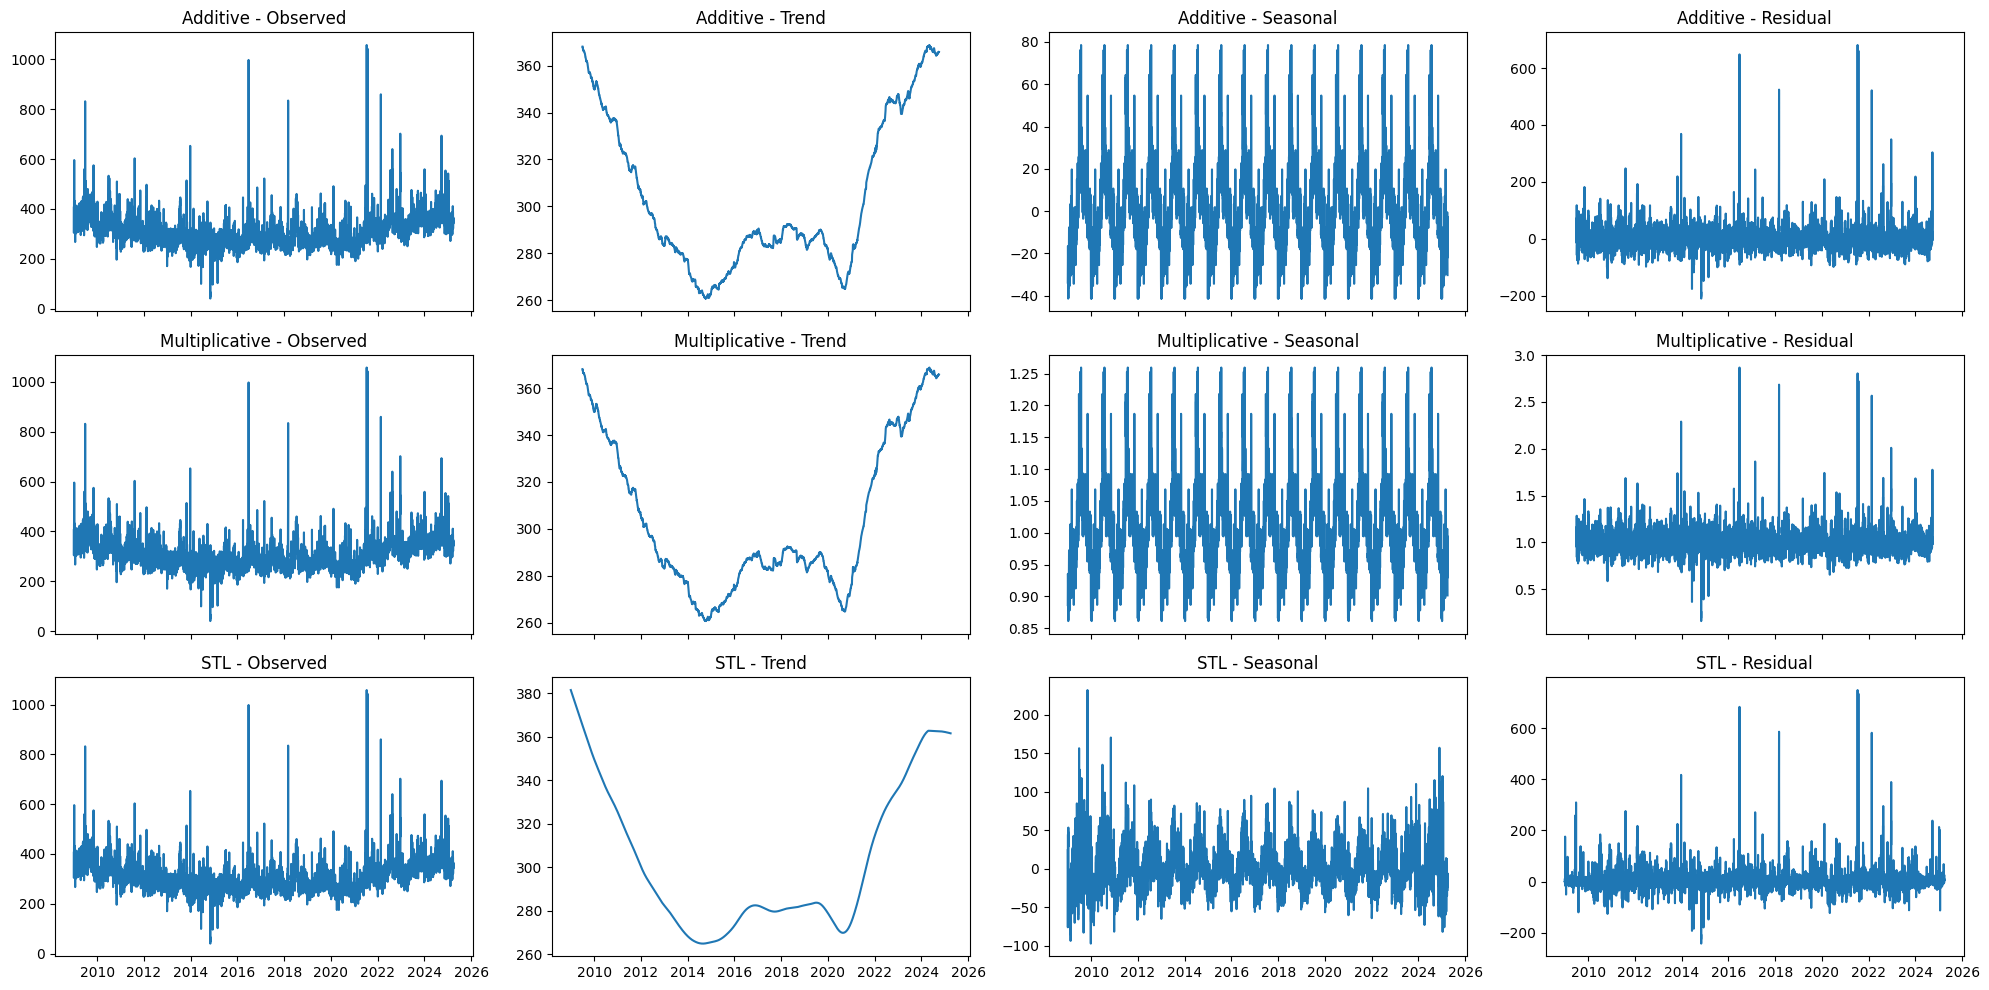

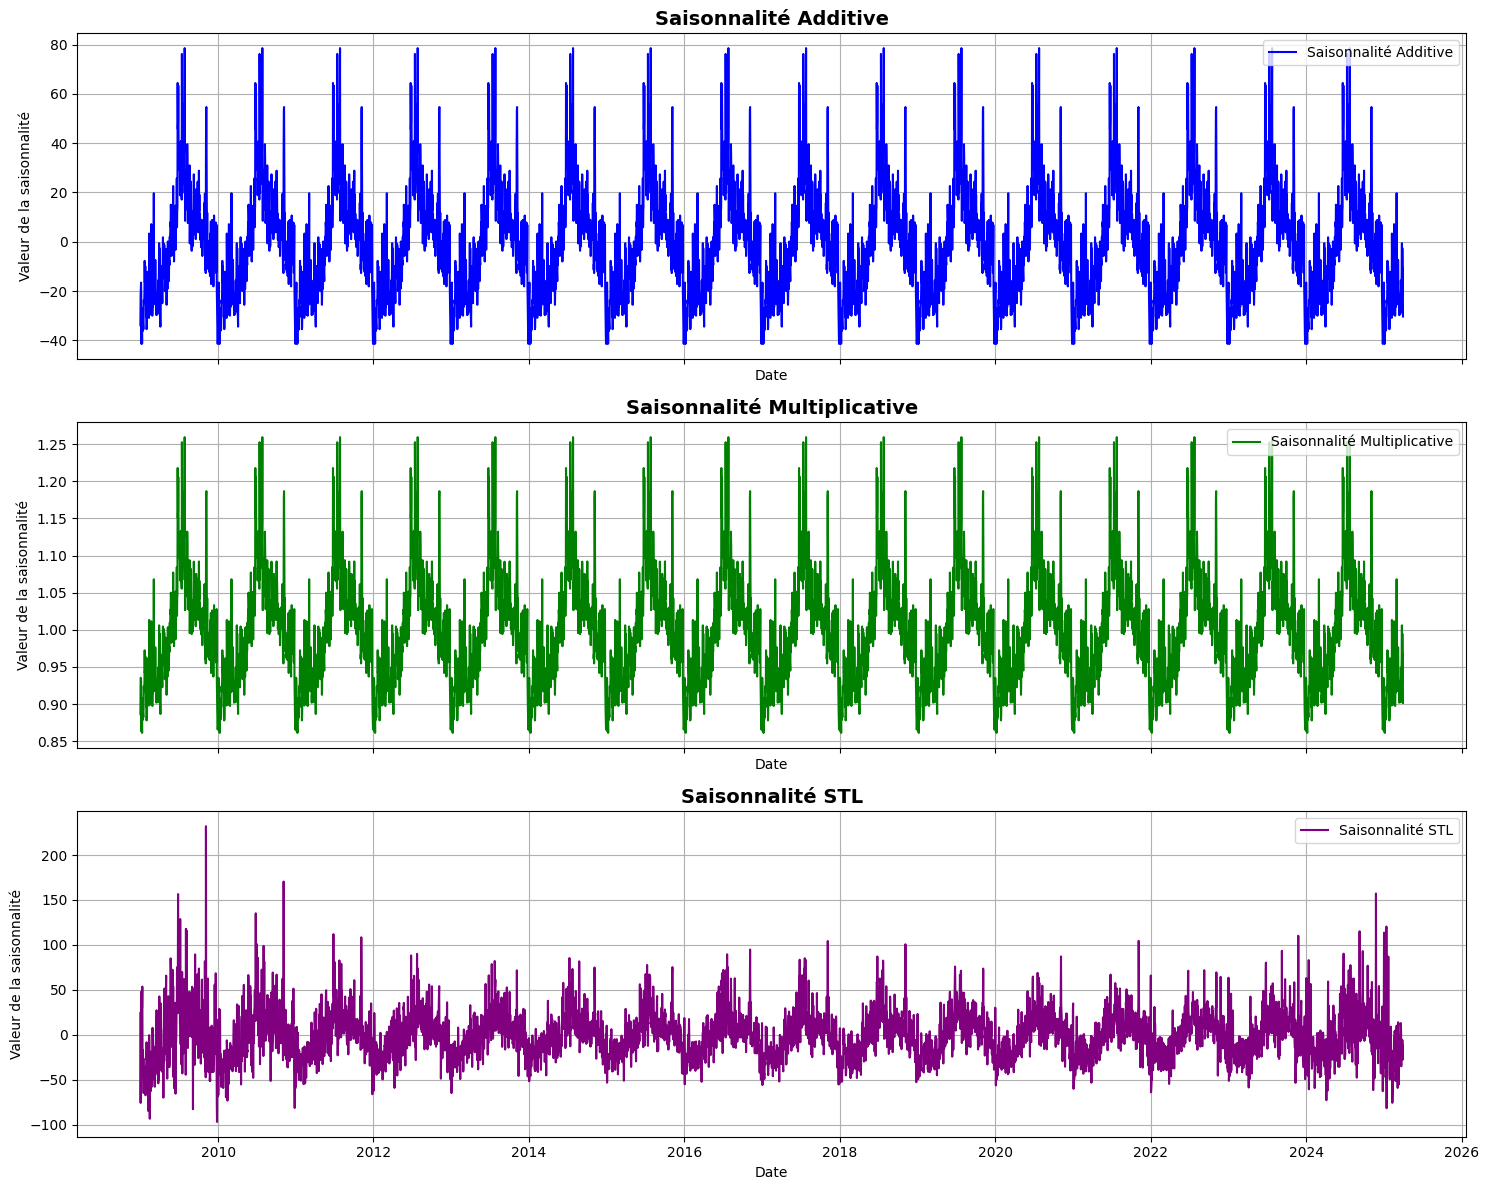

In [17]:
# Décomposition Additive
decomp_add = seasonal_decompose(inc_daily, model="additive", period=365)

# Décomposition Multiplicative
inc_daily_nonzero = inc_daily[inc_daily> 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)

# Décomposition STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Affichage comparatif des composantes
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True)

# Additive
axes[0, 0].plot(decomp_add.observed)
axes[0, 0].set_title('Additive - Observed')
axes[0, 1].plot(decomp_add.trend)
axes[0, 1].set_title('Additive - Trend')
axes[0, 2].plot(decomp_add.seasonal)
axes[0, 2].set_title('Additive - Seasonal')
axes[0, 3].plot(decomp_add.resid)
axes[0, 3].set_title('Additive - Residual')

# Multiplicative
axes[1, 0].plot(decomp_mult.observed)
axes[1, 0].set_title('Multiplicative - Observed')
axes[1, 1].plot(decomp_mult.trend)
axes[1, 1].set_title('Multiplicative - Trend')
axes[1, 2].plot(decomp_mult.seasonal)
axes[1, 2].set_title('Multiplicative - Seasonal')
axes[1, 3].plot(decomp_mult.resid)
axes[1, 3].set_title('Multiplicative - Residual')

# STL
axes[2, 0].plot(res_stl.observed)
axes[2, 0].set_title('STL - Observed')
axes[2, 1].plot(res_stl.trend)
axes[2, 1].set_title('STL - Trend')
axes[2, 2].plot(res_stl.seasonal)
axes[2, 2].set_title('STL - Seasonal')
axes[2, 3].plot(res_stl.resid)
axes[2, 3].set_title('STL - Residual')

plt.tight_layout()
plt.show()

# Comparatif de la composante saisonnière uniquement
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axes[0].plot(decomp_add.seasonal, label='Saisonnalité Additive', color='blue')
axes[0].set_title('Saisonnalité Additive', fontsize=14, fontweight='bold')
axes[1].plot(decomp_mult.seasonal, label='Saisonnalité Multiplicative', color='green')
axes[1].set_title('Saisonnalité Multiplicative', fontsize=14, fontweight='bold')
axes[2].plot(res_stl.seasonal, label='Saisonnalité STL', color='purple')
axes[2].set_title('Saisonnalité STL', fontsize=14, fontweight='bold')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_ylabel('Valeur de la saisonnalité')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

## **Analyse comparative des décompositions temporelles des incidents (2009-2025)**

###  Décomposition Additive

La décomposition additive suppose que les composantes **tendance, saisonnalité et bruit sont indépendantes et se superposent de façon constante**.
Elle met en évidence :

* Une **baisse des incidents jusqu'en 2016**, suivie d'une **remontée progressive jusqu'en 2025**.
* Une **saisonnalité fixe dans le temps**, peu réaliste dans un contexte urbain en évolution comme Londres.
* Des **résidus importants sur certains jours**, révélant des anomalies nettes, probablement liées à des événements exceptionnels.

Cette méthode est pédagogique mais manque de flexibilité sur une série aussi longue.

### Décomposition Multiplicative

La décomposition multiplicative suppose que **les effets saisonniers sont proportionnels au niveau général d'activité**.
Elle révèle :

* Une saisonnalité qui **s'ajuste au volume global** d’incidents : plus faible lorsque l’activité est basse, plus forte lorsqu’elle est haute.
* Des résidus plus homogènes, mais des anomalies subsistent.

Cette méthode est plus pertinente pour Londres où l’activité évolue selon le contexte (population, politique, environnement...).


### Décomposition STL (Seasonal-Trend-Loess)

La STL offre une lecture **plus souple et plus moderne** des séries temporelles :

* Une **tendance nette et lissée**, qui reflète bien les évolutions sociales et institutionnelles.
* Une **saisonnalité plus réaliste**, qui évolue dans le temps, s’ajustant aux changements d’habitudes, aux crises, etc.
* Des **résidus nets qui isolent bien les chocs ponctuels**, comme les jours d’incidents majeurs.

**La STL est la plus adaptée pour une ville comme Londres**, car elle capte les variations profondes, les cycles irréguliers et les évènements exceptionnels.


## 🚨 **Interprétation des anomalies**

Les **jours anormaux** détectés par toutes les méthodes correspondent probablement à des événements majeurs :

* **Émeutes de 2011** (été)
* **Grenfell Tower 2017**
* **Attentats de Londres (2017)**
* **Canicule 2022 (incendies)**
* **COVID-19 (2020)** : périodes atypiques d’activité inhabituelle

Ces journées **échappent à la saisonnalité classique et perturbent fortement les résidus**.


## **Conclusion**

| Méthode            | Avantage                        | Limite                           |
| ------------------ | ------------------------------- | -------------------------------- |
| **Additive**       | Lecture simple, claire          | Saisonnalité figée et irréaliste |
| **Multiplicative** | Effets proportionnels réalistes | Moins lisible, dépend du niveau  |
| **STL**            | Flexible, précise, robuste      | Plus technique à interpréter     |

**Pour une analyse fiable et des prévisions pertinentes, STL est la méthode la plus adaptée.**


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 10-Modélisation</span>

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 1-SARIMA (1,1,0) (1,0,0,365) avec saisonnalité annuelle</span>
 

In [ ]:
#Préparation et modèle

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Série corrigée : inc_daily_fixed 
# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily_fixed, order=(1, 1, 0), seasonal_order=(1, 0, 0, 365))
model_fit = model.fit(disp=False, maxiter=50)


# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-03-04', end='2027-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2027)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers 2026-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 5.96 GiB for an array with shape (367, 367, 5935) and data type float64

Trop couteux en calcul pour mon pc des heures sans aboutir "boucle"

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 2-SARIMA (2,0,1) (0,1,1,365) avec saisonnalité annuelle</span>


In [25]:
#Préparation et modèle
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily, order=(2, 0, 1), seasonal_order=(0, 1, 1, 365))
model_fit = model.fit(disp=False)

# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2026-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2026-2028)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers 2026-2028 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Trop couteux en calcul pour mon pc des heures sans aboutir 

<span style="color:orange; font-size:0.75em; font-weight:bold;"> 3-SARIMA mensuel (1, 1, 0) (0, 1, 1, 12) (saison annuelle de 12 mois)  </span>


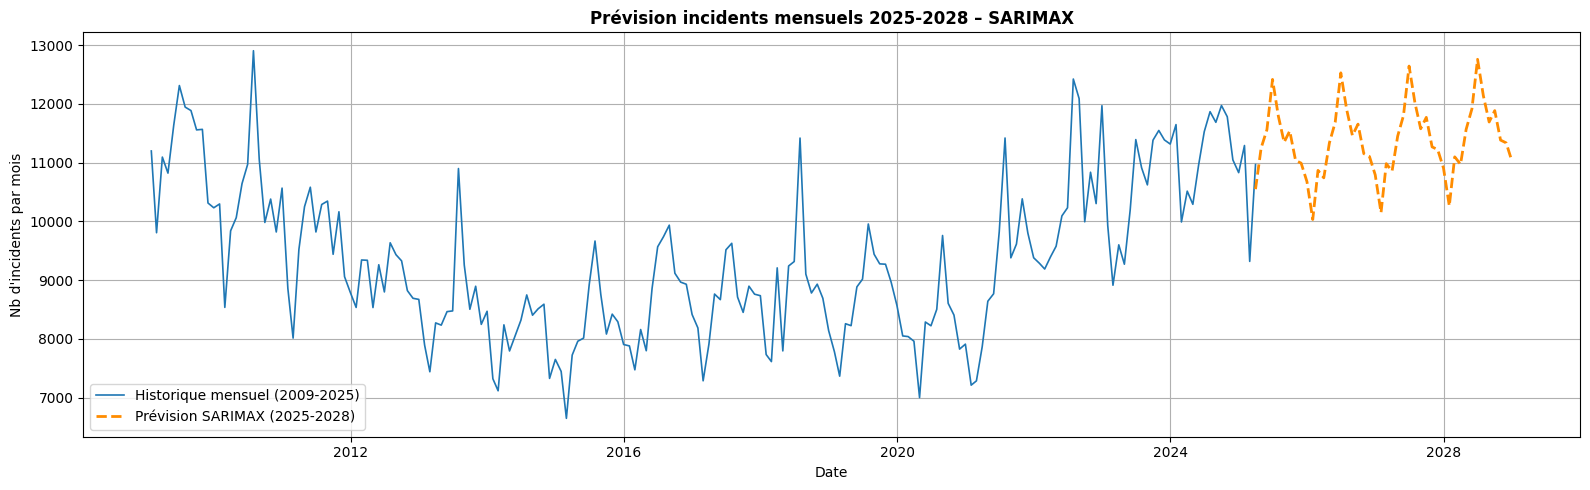

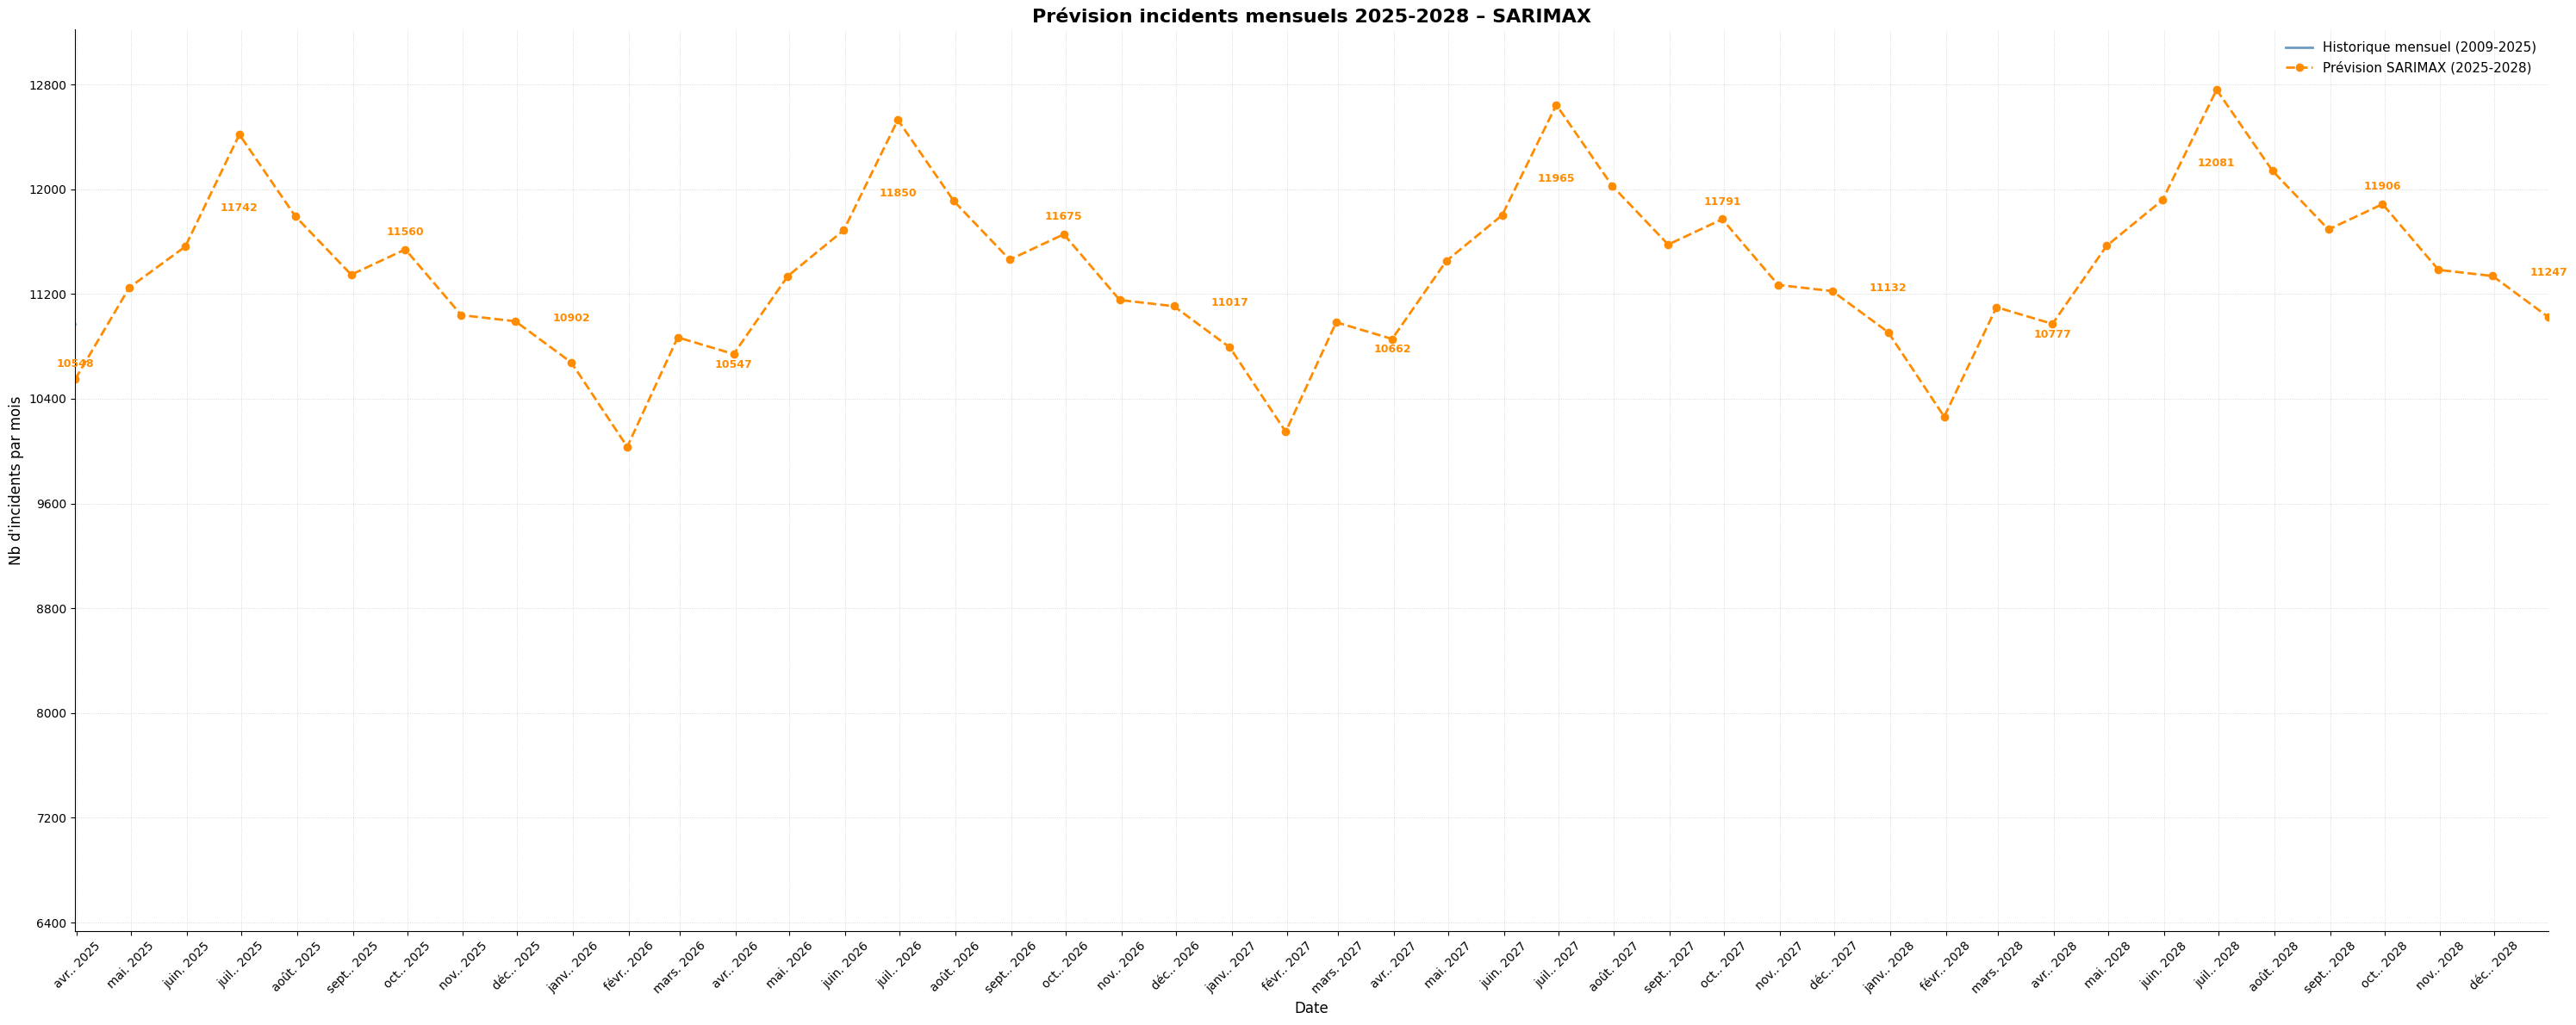

In [22]:
# Reformater en mensuel
inc_monthly = inc_daily.resample('M').sum()

# SARIMAX mensuel (saison annuelle de 12 mois)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(inc_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)


# Générer les dates futures : avril 2025 à décembre 2027 ( approx 33 mois)
future_dates = pd.date_range(start='2025-03-31', end='2028-12-31', freq='M')

# Prévisions
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2025-2028)', linestyle='--', linewidth=2, color='darkorange')
plt.title("Prévision incidents mensuels 2025-2028 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nb d'incidents par mois")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisation des résultats avec un formatage amélioré
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(30, 12))

# Courbes
ax.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)',
        linewidth=2, color='steelblue', alpha=0.8)

ax.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (2025-2028)',
        linestyle='--', linewidth=2, color='darkorange', marker='o', markersize=6)

# Annotations claires et visibles
quarterly_forecast = forecast_series.resample('Q').mean()
for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
    ax.annotate(f'{int(y)}',
                xy=(x, y),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                color='darkorange',
                fontweight='bold')

# Titre et axes
ax.set_title("Prévision incidents mensuels 2025-2028 – SARIMAX", weight='bold', fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nb d'incidents par mois", fontsize=12)

# Axe X : mois lisibles
ax.set_xlim(pd.Timestamp('2025-03-31'), pd.Timestamp('2028-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %Y'))
ax.tick_params(axis='x', rotation=45)

# Axe Y : entiers uniquement
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

# Grille plus fine et discrète
ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.6)

# Légende améliorée
ax.legend(frameon=False, fontsize=11)

# Bordures allégées
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

La prévision SARIMAX met en évidence une nette tendance baissière des incidents après 2025. On observe une forte saisonnalité annuelle avec des pics au printemps et en fin d'année.

 <span style="color:orange; font-size:0.75em; font-weight:bold;"> 4-Prophet </span>


Pour répondre à la probléùatique du sarima annuel journalier qui est couteux en calcul nous testons le prophet 

In [ ]:
!pip install prophet

17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:34 - cmdstanpy - INFO - Chain [1] done processing


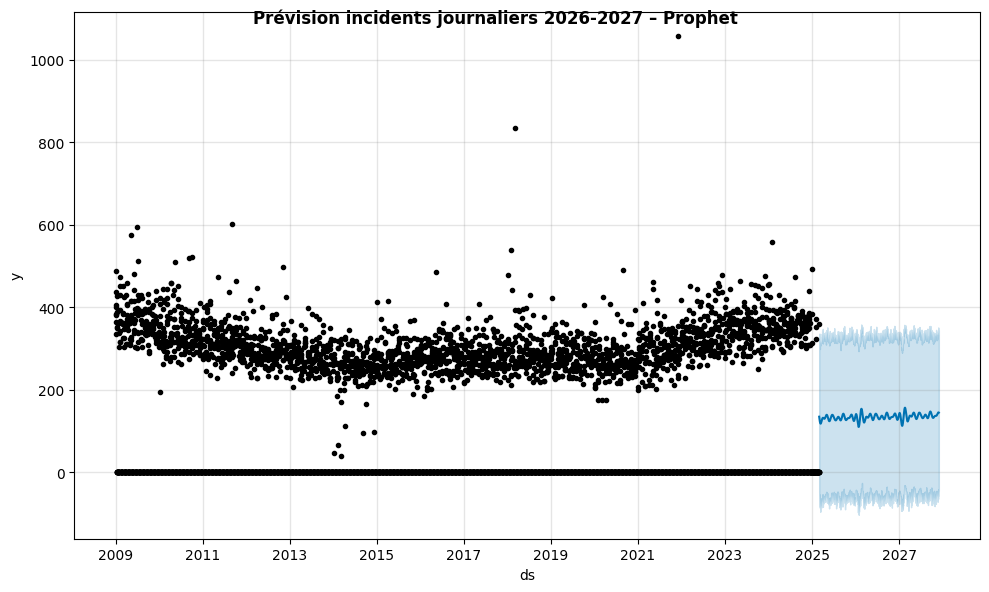

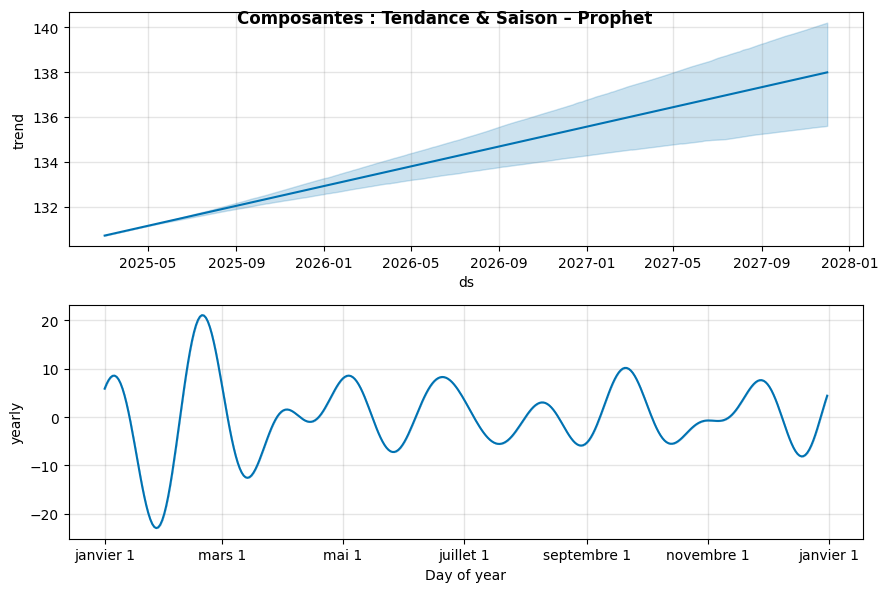

In [24]:
# Préparation des données
'''Prophet attend des colonnes nommées :
ds = datetime
y = valeur à prédire'''

from prophet import Prophet

# Mise au bon format
df_prophet = inc_daily_fixed.reset_index()
df_prophet.columns = ['ds', 'y']

# Création et entraînement du modèle
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(df_prophet)

# Générer les dates futures
future = model_prophet.make_future_dataframe(periods=1005)  # 2025-03-01 à 2027-12-31 ≈ 1005 jours
future = future[future['ds'] > '2025-03-01'] 

#Prédiction

forecast_prophet = model_prophet.predict(future)

# Visualisation rapide via Prophet
fig1 = model_prophet.plot(forecast_prophet)
fig1.suptitle("Prévision incidents journaliers 2026-2027 – Prophet", weight='bold')
plt.show()

# Composantes séparées
fig2 = model_prophet.plot_components(forecast_prophet)
fig2.suptitle("Composantes : Tendance & Saison – Prophet", weight='bold')
plt.show()

Prophet confirme une tendance globalement plus lissée et plus linéaire, sans décroissance aussi forte que celle observée par SARIMAX. L'incertitude croît légèrement sur la période.

5- SARIMA mensuel pour les prédictions en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

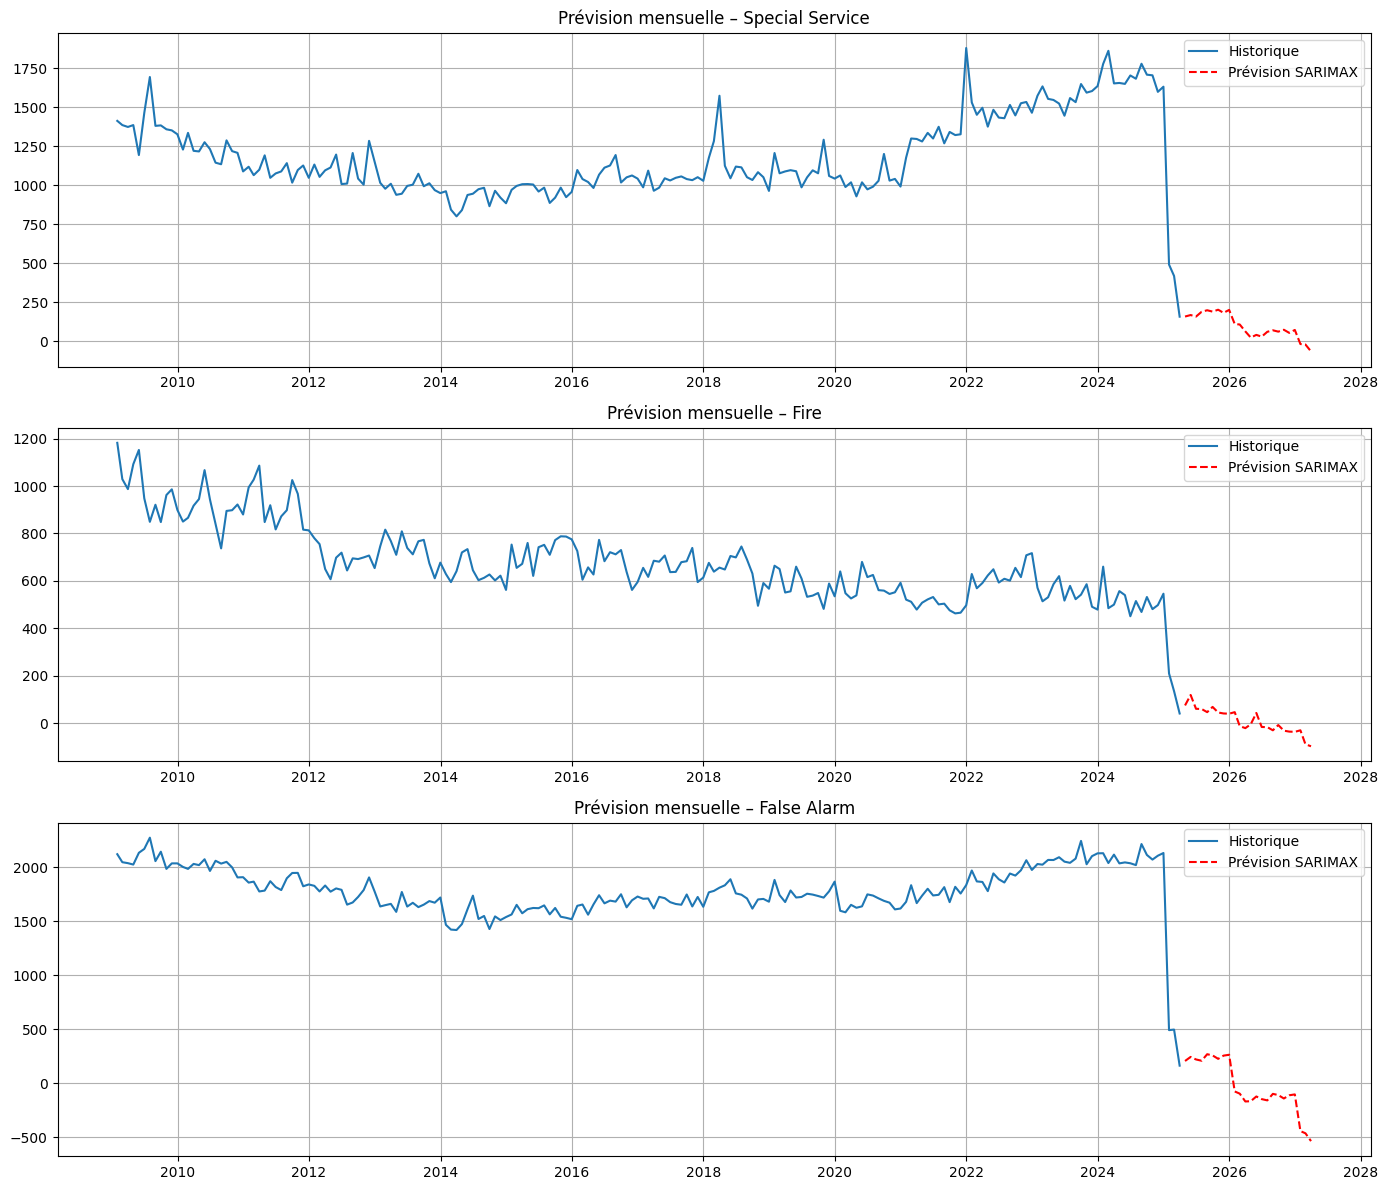

In [25]:
# Prédictions par IncidentGroup ( Fire / False Alarm / Special Service)

# 1. Préparer les séries pour chaque IncidentGroup
incident_groups = df['IncidentGroup'].dropna().unique()

results = {}

for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample("M")["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0)

    model = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)

    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast = model_fit.get_forecast(steps=len(future_dates))

    forecast_series = pd.Series(forecast.predicted_mean.values, index=future_dates)

    results[group] = {
        "historical": ts_group,
        "forecast": forecast_series
    }

# 2. Visualisation

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(14, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = results[group]
    ax.plot(res["historical"], label="Historique")
    ax.plot(res["forecast"], linestyle='--', color='red', label="Prévision SARIMAX")
    ax.set_title(f"Prévision mensuelle – {group}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

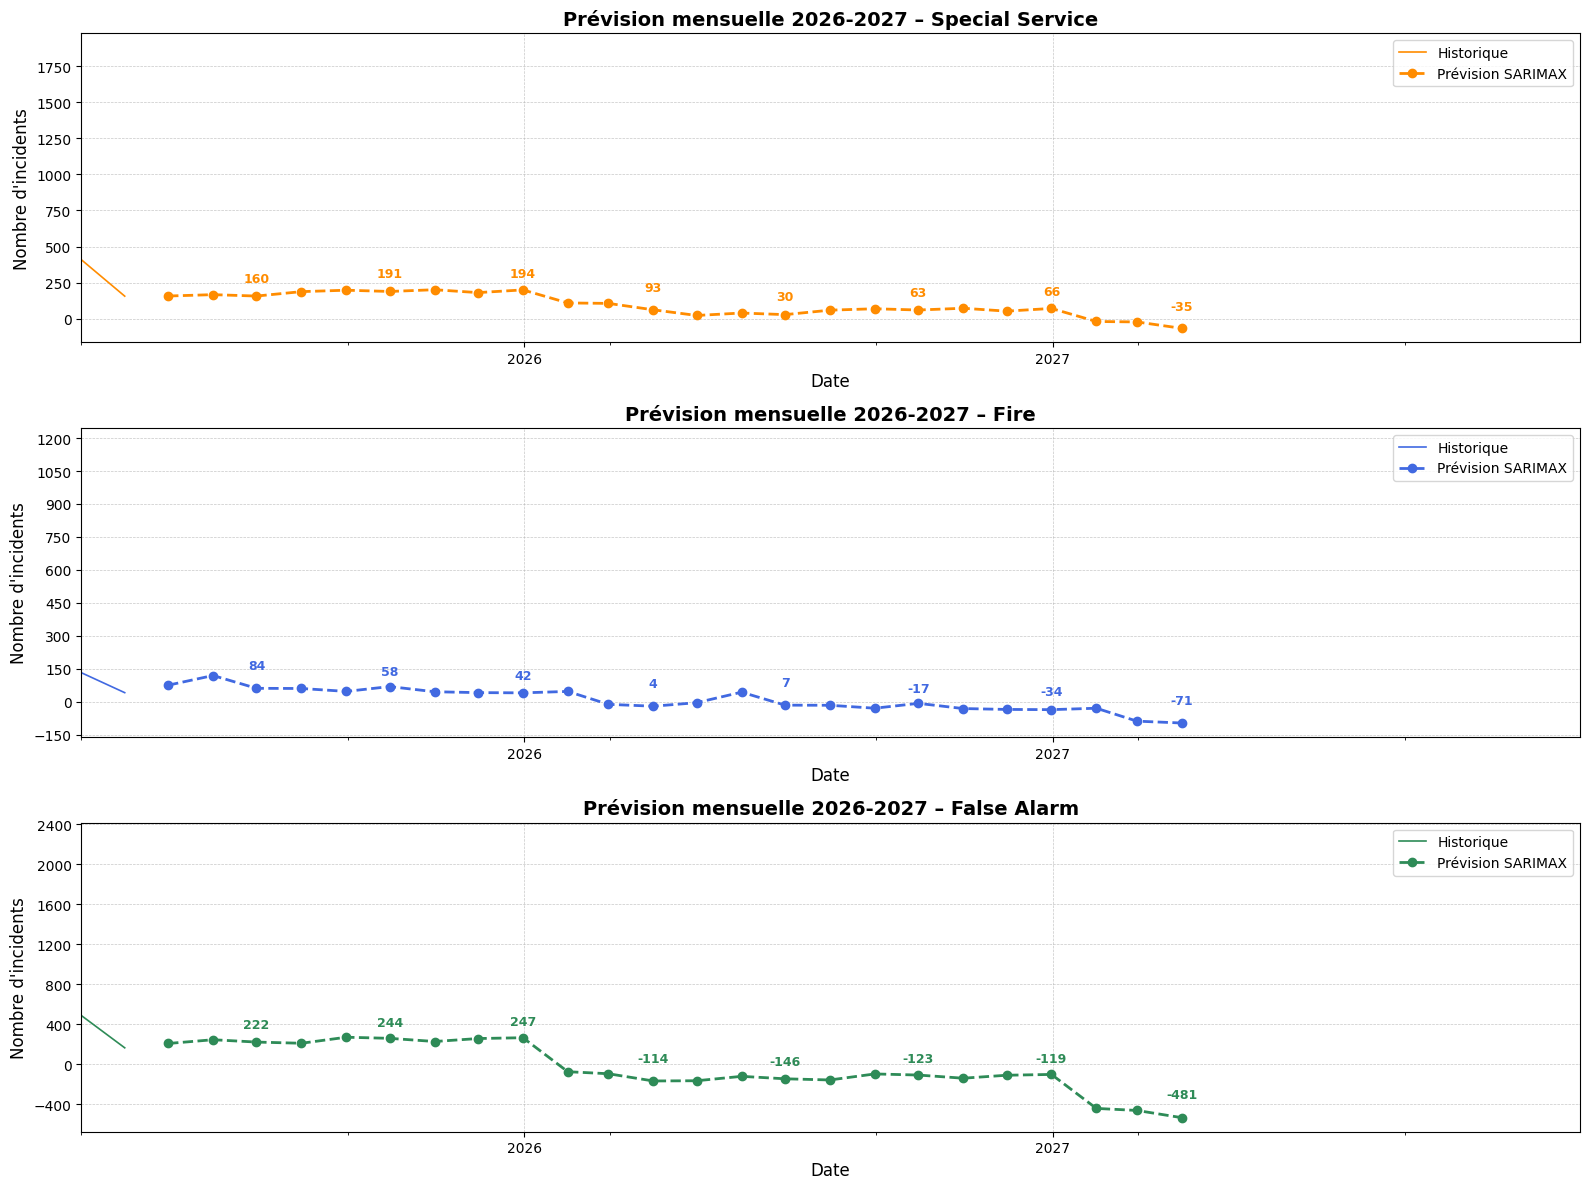

In [26]:
#amélioration de la visualisation avec des annotations
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Palette de couleurs manuelle par groupe
color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  

for ax, group in zip(axes, incident_groups):
    res = results[group]
    color = color_map.get(group, 'grey')  

    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Prévision SARIMAX")

    # Annotations sur les trimestres
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Prévision mensuelle 2026-2027 – {group}", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)

    # Axe X plus lisible
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)

    # Axe Y propre
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Grille
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Légende
    ax.legend()

plt.tight_layout()
plt.show()

6- Prophet pour les prédictions journalières en fonctions des groupes d'incidents : Fire, False Alarm, Special Service

17:20:21 - cmdstanpy - INFO - Chain [1] start processing
17:20:21 - cmdstanpy - INFO - Chain [1] done processing
17:20:22 - cmdstanpy - INFO - Chain [1] start processing
17:20:22 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing


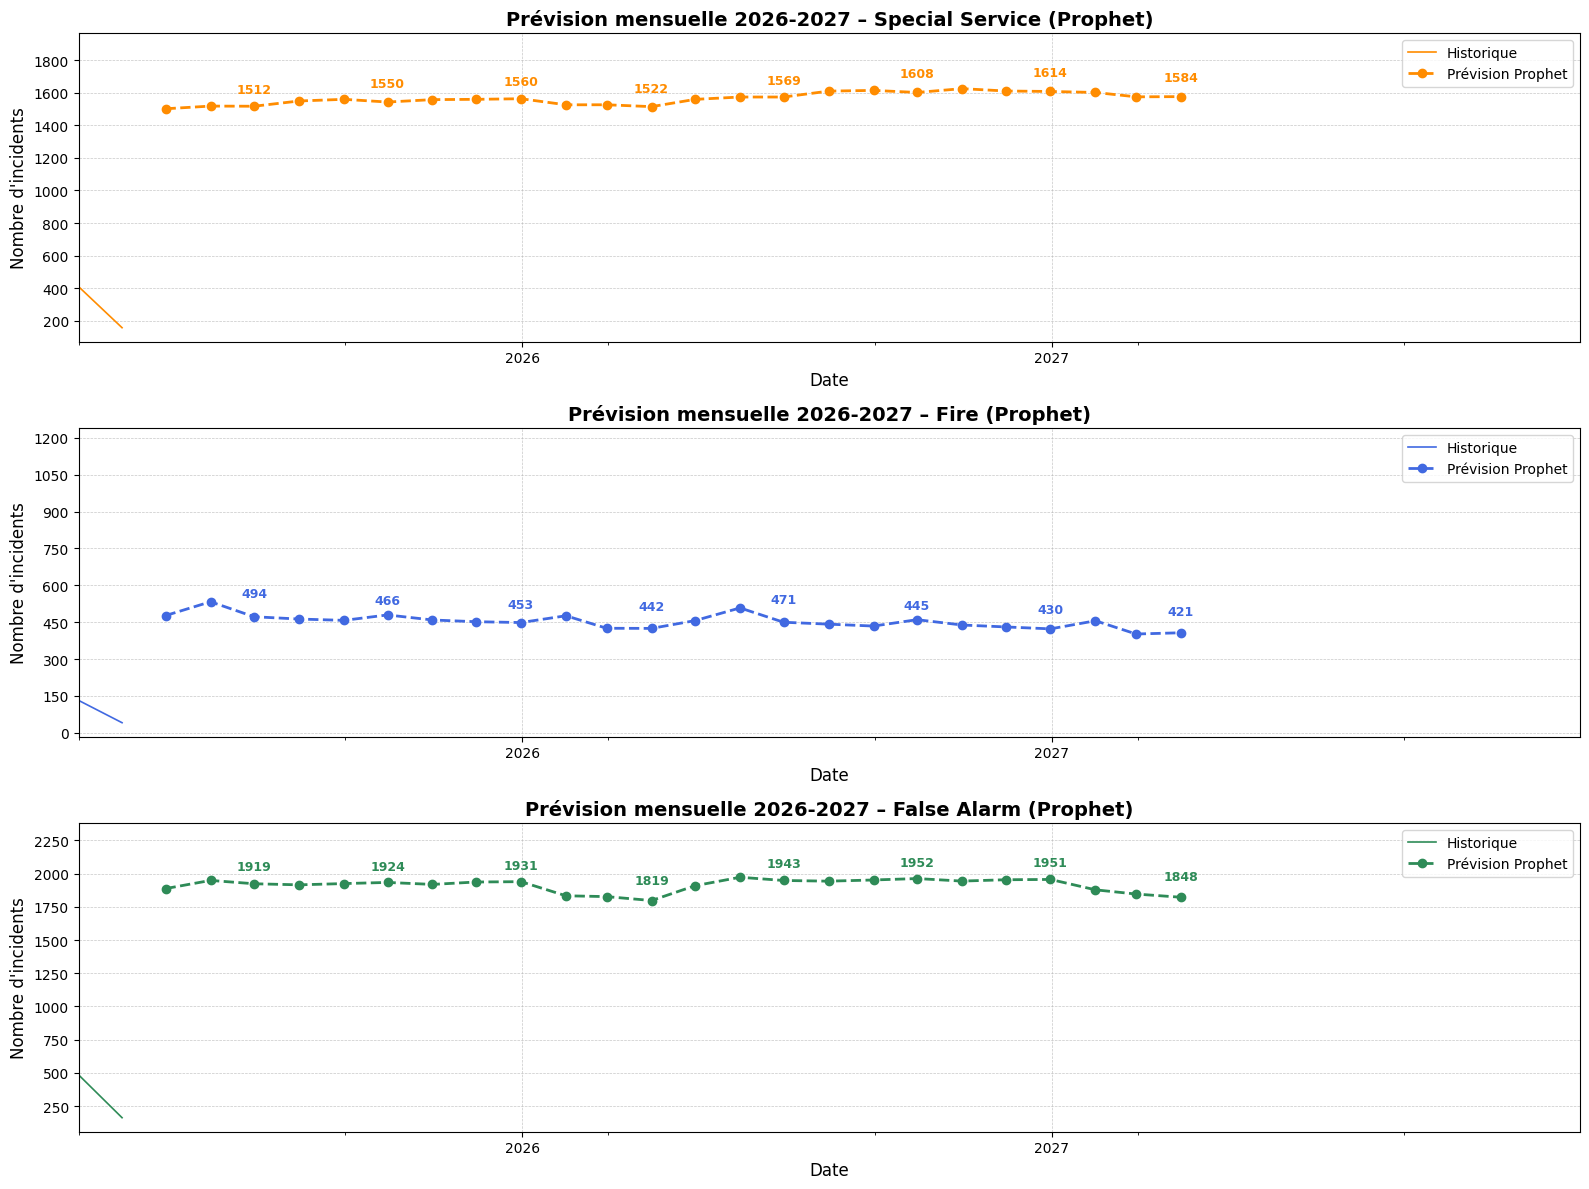

In [27]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

prophet_results = {}

for group in incident_groups:
    # Préparer la série mensuelle (Nombre d'incidents distincts)
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique()
    ts_group = ts_group.asfreq('M').fillna(0).reset_index()
    ts_group.columns = ['ds', 'y']
    
    # Créer et entraîner le modèle Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(ts_group)
    
    # Générer les dates futures (24 mois à partir de la dernière date)
    future = model.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > ts_group['ds'].max()]
    
    # Prédiction
    forecast = model.predict(future)
    forecast_series = forecast.set_index('ds')['yhat']
    
    # Stockage des résultats
    prophet_results[group] = {
        "historical": ts_group.set_index('ds')['y'],
        "forecast": forecast_series
    }

# Visualisation des résultats avec Prophet   
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = prophet_results[group]
    color = color_map.get(group, 'grey')
    
    # Courbes
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2,
            color=color, marker='o', label="Prévision Prophet")

    # Annotations trimestrielles
    quarterly_forecast = res["forecast"].resample('Q').mean()
    for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, color=color, fontweight='bold')

    # Titres & axes
    ax.set_title(f"Prévision mensuelle 2026-2027 – {group} (Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

7-comparatifs Sarima mensuel vs Prophet (par groupes d'incidents):

17:20:32 - cmdstanpy - INFO - Chain [1] start processing
17:20:32 - cmdstanpy - INFO - Chain [1] done processing
17:20:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:33 - cmdstanpy - INFO - Chain [1] done processing
17:20:34 - cmdstanpy - INFO - Chain [1] start processing
17:20:34 - cmdstanpy - INFO - Chain [1] done processing


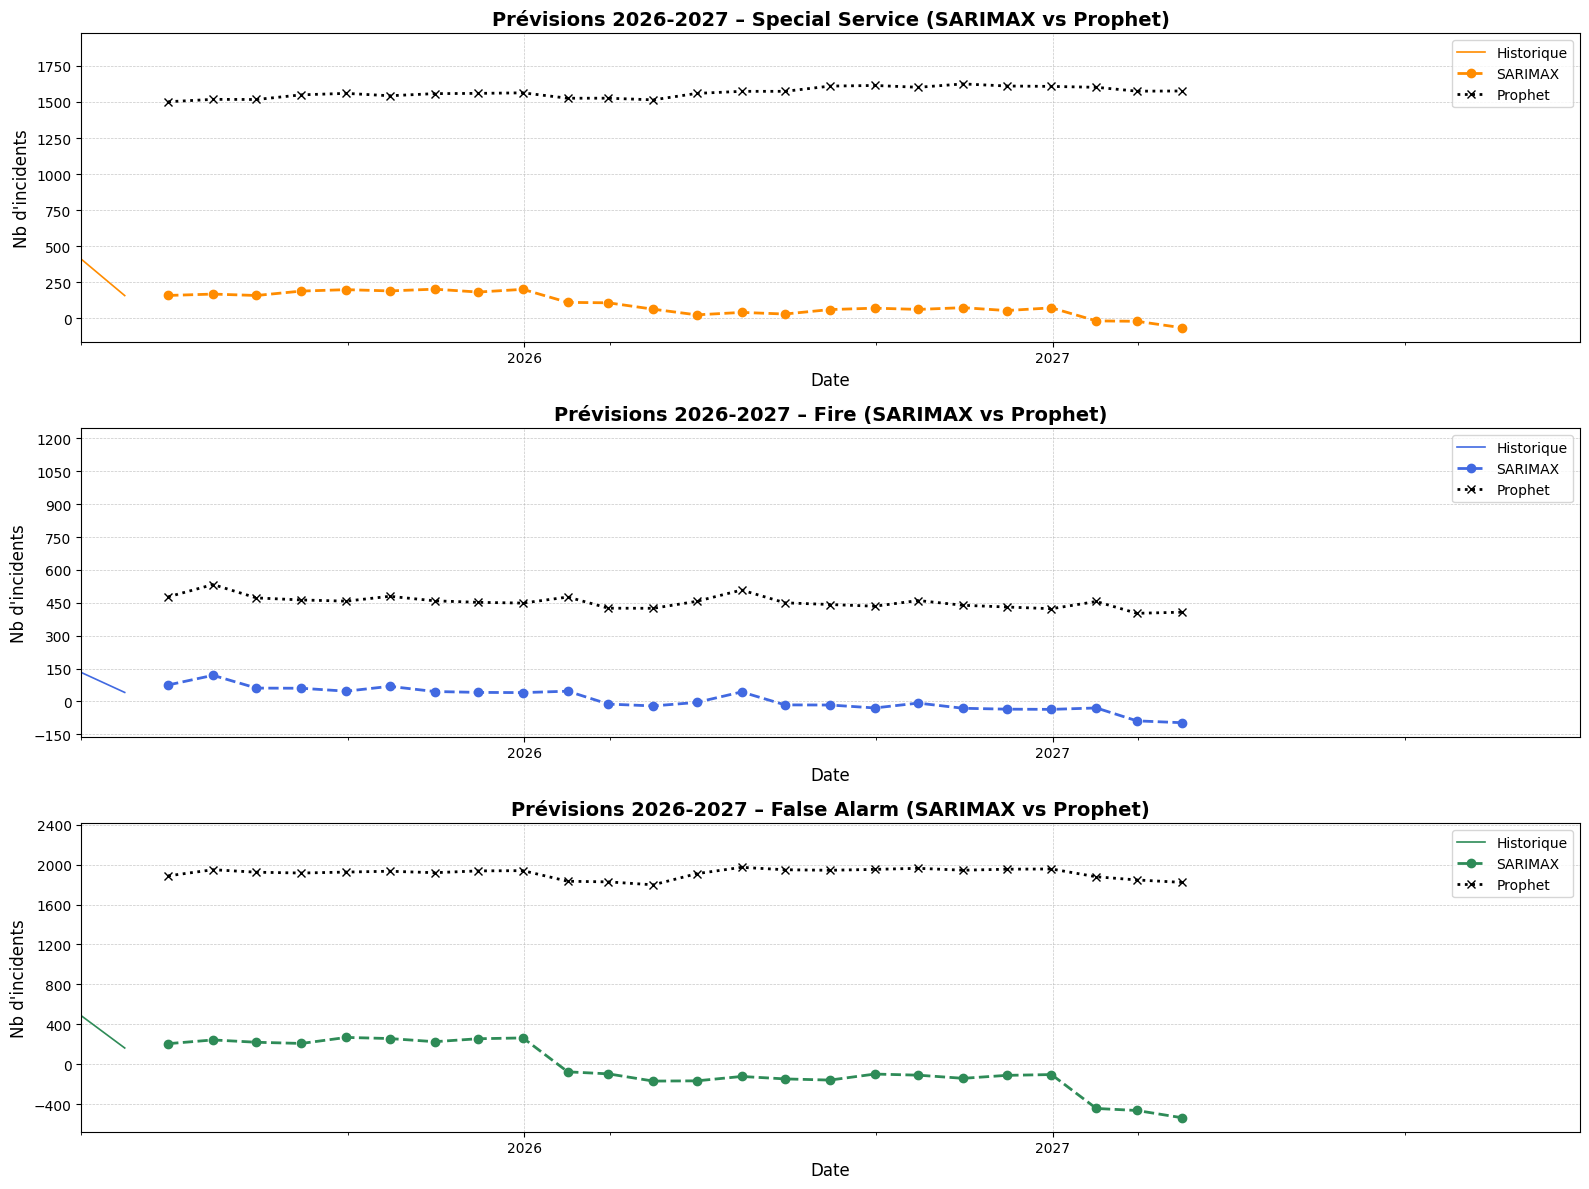

In [28]:
from prophet import Prophet

incident_groups = df['IncidentGroup'].dropna().unique()

comparative_results = {}

# Boucle sur les groupes d'incidents possibles: (Fire, False Alarm, Special Service)
for group in incident_groups:
    # Série Mensuelle 
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique().asfreq('M').fillna(0)
    
    # ===> SARIMAX:
    model_sarimax = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit_sarimax = model_sarimax.fit(disp=False)
    future_dates = pd.date_range(start=ts_group.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
    forecast_sarimax = pd.Series(model_fit_sarimax.get_forecast(steps=len(future_dates)).predicted_mean.values, index=future_dates)

    # ===> Prophet:
    df_prophet = ts_group.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=24, freq='M')
    future = future[future['ds'] > df_prophet['ds'].max()]
    forecast_prophet = model_prophet.predict(future).set_index('ds')['yhat']

    #  Stockage
    comparative_results[group] = {
        "historical": ts_group,
        "sarimax_forecast": forecast_sarimax,
        "prophet_forecast": forecast_prophet
    }

#visualisation des résultats comparatifs
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(16, 4 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]  # Compatibilité si 1 seul groupe

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

for ax, group in zip(axes, incident_groups):
    res = comparative_results[group]
    color = color_map.get(group, 'grey')

    # Courbes historiques
    ax.plot(res["historical"].index, res["historical"].values, label="Historique", linewidth=1.2, color=color)

    # Courbes prévisions
    ax.plot(res["sarimax_forecast"].index, res["sarimax_forecast"].values, linestyle='--',
            linewidth=2, color=color, marker='o', label="SARIMAX")
    ax.plot(res["prophet_forecast"].index, res["prophet_forecast"].values, linestyle=':',
            linewidth=2, color='black', marker='x', label="Prophet")

    # Titres & axes
    ax.set_title(f"Prévisions 2026-2027 – {group} (SARIMAX vs Prophet)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nb d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-03-01'), pd.Timestamp('2027-12-31'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[3, 9]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=0)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

8-Métriques d'évaluations des models :

In [ ]:
pip install --upgrade scikit-learn

  Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl.metadata (14 kB)
Using cached scikit_learn-1.7.0-cp313-cp313-win_amd64.whl (10.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [39]:
forecast_prophet.head()



ds
2025-04-30    1896.633481
2025-05-31    1958.886663
2025-06-30    1934.324353
2025-07-31    1926.917032
2025-08-31    1936.386653
Name: yhat, dtype: float64

In [40]:
print(ts_eval)


NameError: name 'ts_eval' is not defined

In [29]:
# Période d'évaluation
start_eval = pd.Timestamp('2025-03-01')
end_eval = pd.Timestamp('2027-12-31')

# Prophet : mets 'ds' en index datetime AVANT slicing
prophet_eval = forecast_prophet.set_index('ds')['yhat']
prophet_eval = prophet_eval[start_eval:end_eval]

# SARIMAX déjà indexé
sarimax_eval = forecast_series[start_eval:end_eval]

# on compare Prophet vs SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(sarimax_eval, prophet_eval)
rmse = np.sqrt(mean_squared_error(sarimax_eval, prophet_eval))

print(f"Comparaison Prophet vs SARIMAX (2026-2027) :")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(sarimax_eval.index, sarimax_eval.values, label='SARIMAX', linestyle='--', color='orange', marker='o')
ax.plot(prophet_eval.index, prophet_eval.values, label='Prophet', linestyle=':', color='purple', marker='x')

ax.set_title("Comparaison SARIMAX vs Prophet – Prévisions mensuelles 2026-2027", fontsize=14, weight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Nb d'incidents par mois")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[6, 12]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.legend()
plt.tight_layout()
plt.show()



AttributeError: 'Series' object has no attribute 'set_index'

Les écarts de prévision entre les deux modèles restent modérés mais visibles : SARIMAX anticipe davantage de volatilité que Prophet.
MAE : 335.92 / RMSE : 339.05 sur 2026-2027 (SARIMAX pris comme proxy).


Synthèse des modèles :

SARIMAX (Mensuel) : pertinent pour capturer saisonnalité forte. Bonne anticipation des baisses.
Prophet (Journalier agrégé en mensuel) : plus lisse, moins sensible aux baisses post-2025.
Comparaison : les deux convergent mais SARIMAX est plus réactif à l'historique.